# Вводная информация об объекте исследования
Вы будете работать с данными, которые собираются с самосвалов, перевозящих породу (например, уголь) на карьере. На самосвалах стоят датчики, которые собирают множество различной информации (скорость, высота, расход топлива и тд). Данные с каждого датчика приходят вместе с временной меткой, идентификатором самосвала и его местоположением (координатами) в момент получения значения с датчика.

Сам по себе карьер состоит из пунктов погрузки (откуда вывозят породу), пунктов разгрузки (куда её отвозят) и маршрутов между ними. На картинке показан пример исходных данных координат самосвалов (синие точки) и примерных дорог на карьере (фиолетовые). Пункты погрузки и разгрузки на картинке не указаны.

Одним рейсом самосвала называется его движение от пункта погрузки до пункта разгрузки и обратно до пункта погрузки.

![](https://drive.google.com/uc?export=view&id=1QLscdUpjOGU8m9WvN8ulKdC9YBWJyKw4)

## Данные:

**telemetry.parquet** - данные телеметрии
* objectid - идентификатор самосвала
* tripid - идентификатор рейса
* driverid - идентификатор водителя
* time - время получения данных с датчиков
* lat, lon - широта и долгота самосвала в текущий момент времени
* x, y, - координаты самосвала на плоскости (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
* speed - данные с датчика скорости
* height - высота в текущий момент времени
* engine_speed - обороты двигателя
* fuel_cons - мгновенный расход топлива
* fuel_tank_level - уровень топлива в баке (в процентах)
* weight_dynamic - мгновенное значение веса с датчика (растет, пока самосвал грузит, колеблется вокруг константы, когда едет загруженный и обнуляется при разгрузке и движении без груза обратно на погрузку)
* weight - значение веса груза, который перевез самосвал за текущий рейс (константа для каждого рейса. Даже на той части рейса, где самосвал ехал пустым обратно на погрузку значение этого параметра будет равно весу груза)
* DQ_vertical_bump - вертикальное ускорения
* accelerator_position - позиция педали газа
* w_fl - ?

Пропуски в колонках fuel_tank_level и weight_dynamic обусловлены тем, что эти датчики собираются с меньшей дискретностью (условно, раз в 10 секунд, а не раз в секунду). При необходимости, можно восполнить Nan значения последним определенным значением (т.е. [1, 2, nan, 3, nan, 4, ...] -> [1, 2, 2, 3, 3, 4, ...])

**weather_hourly.parquet** - почасовая погода на карьере. Значения колонок понятны из их названий.

---

<a id = 'title'></a>


---

Задание 1

- [Отобразить на графике все местоположения самосвалов из исходных данных (предварительно убрав очевидные выбросы по координатам) = карта карьера (пока некорректная из-за ещё некоторых проблем с координатами)](#задание1_1)
- [Обнаружить самосвал(ы), для которых всё ещё есть проблемы с координатами (обозначить их идентификаторы)](#задание1_2)
- [Понять, по какому параметру можно избавиться от этих выбросов по координатам, и сделать чистку](#задание1_3)
- [Нарисовать корректную карту карьера (если удалость определить, как сделать чистку)](#задание1_4)
- [При необходимости, произвести чистку по другим колонкам (препроцессинг для дальнейшего обучения модели)](#задание1_5)
- [Предположить, что обозначают значения колонки w_fl (путем анализа имеющихся данных) - ответ написать в текстовом поле и обосновать](#задание1_6)

---

Задание 2

- [Вывести средние значения параметров ['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height'] по самосвалам](#задание2_1)
- [Построить гистограмму суммарных расстояний за каждый рейс.](#задание2_2)
- [Вывести таблицу средних скоростей самосвалов за каждый час суток (формат: колонки - час суток, строки - самосвалы, в ячейках - средняя скорость)](#задание2_3)
- [Выбрать по одному рейсу для каждого самосвала. Для каждого рейса: нарисовать его на общей карте карьера, нарисовать на одном графике кривую изменения скорости от времени и высоты от времени (шкалы должны быть на разных осях).](#задание2_4)
 - [Присоединить данные погоды к данным телеметрии](#задание2_5)

---

Задание 3

- [Можно (и даже нужно) генерировать дополнительные фичи.](#задание3_1)
- [Выполнить необходимые (на Ваш взгляд) преобразования датасета.](#задание3_2)
- [Выбрать метрику(и) для оценки качества модели, объяснить причину выбора данной метрики](#задание3_3)
- [Обучить несколько моделей и сравнить их. Интерпретировать результаты.](#задание3_4)


---

Вывод

- [Вывод по опробованным моделям](#itog_1)
- [Тренировка итоговой модели](#itog_2)


# Импорты

In [1]:
# база
import pandas as pd
import numpy as np
import warnings

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error

# pytorch
import torch
import torch.nn as nn

# catboost
from catboost import cv
from catboost import *


# константы
RANDOM_STATE = 42
warnings.filterwarnings("ignore")

c:\Users\oudel\anaconda3\envs\newenv\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [53]:
telemetry = pd.read_parquet('telemetry.parquet')
weather = pd.read_parquet('weather_hourly.parquet')

In [24]:
telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426322 entries, 0 to 426321
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype                                
---  ------                --------------   -----                                
 0   objectid              426322 non-null  int64                                
 1   time                  426322 non-null  datetime64[ns, pytz.FixedOffset(420)]
 2   lat                   426322 non-null  float64                              
 3   lon                   426322 non-null  float64                              
 4   speed                 426322 non-null  float64                              
 5   height                426322 non-null  float64                              
 6   fuel_cons             426322 non-null  float64                              
 7   engine_speed          259203 non-null  float64                              
 8   hdop                  426322 non-null  float64                  

In [25]:
telemetry.head()

objectid                             time        lat        lon     speed  \
0      1121 2023-11-08 05:31:31.309000+07:00  63.328824  83.727988   3.00394   
1      1125        2023-11-08 03:21:39+07:00  63.334962  83.751046   0.00000   
2      1124        2023-11-08 19:20:55+07:00  63.343592  83.739678   4.20000   
3      1124        2023-11-08 14:16:39+07:00  63.343290  83.751773  16.80000   
4      1121 2023-11-08 11:09:49.347000+07:00  63.331924  83.765388   0.00000   

   height  fuel_cons  engine_speed   hdop  DQ_vertical_bump  \
0   195.7     390.00           NaN  99.99                 0   
1   280.0       0.00         0.000   8.00                 0   
2   228.0      66.85       778.000   5.00                 0   
3   278.0       2.45       743.375   6.00                 0   
4    70.9      17.00           NaN  99.99                 0   

   accelerator_position  fuel_tank_level  weight_dynamic     tripid  weight  \
0                     0             60.0           216.0  1003671.0   215.0   
1                     0              NaN             NaN  1003657.0   216.0   
2                     0              NaN             NaN  1003798.0   217.0   
3                     0              NaN             NaN  1003749.0   209.0   
4                     0             38.0             0.0  1003728.0   204.0   

   driverid  w_fl              x             y  
0    2891.0     1  636592.202274  7.025133e+06  
1    2887.0     0  637716.857273  7.025866e+06  
2    2875.0     0  637106.943106  7.026803e+06  
3    2875.0     0  637713.403209  7.026795e+06  
4    2894.0     0  638449.084136  7.025559e+06

## Задание 1

* Отобразить на графике все местоположения самосвалов из исходных данных (предварительно убрав очевидные выбросы по координатам) = карта карьера (пока некорректная из-за ещё некоторых проблем с координатами)
* Обнаружить самосвал(ы), для которых всё ещё есть проблемы с координатами (обозначить их идентификаторы)
* Понять, по какому параметру можно избавиться от этих выбросов по координатам, и сделать чистку
* Нарисовать корректную карту карьера (если удалость определить, как сделать чистку)
* При необходимости, произвести чистку по другим колонкам (препроцессинг для дальнейшего обучения модели)
* Предположить, что обозначают значения колонки w_fl (путем анализа имеющихся данных) - ответ написать в текстовом поле и обосновать

<a id = 'задание1_1'></a>

##### Отобразить на графике все местоположения самосвалов из исходных данных (предварительно убрав очевидные выбросы по координатам) = карта карьера (пока некорректная из-за ещё некоторых проблем с координатами)

[к оглавлению](#title)

In [26]:
telemetry['x'].describe()

count    426322.000000
mean     637310.774179
std        3259.147072
min           0.000000
25%      636595.910597
50%      637670.310177
75%      637887.903113
max      639639.257576
Name: x, dtype: float64

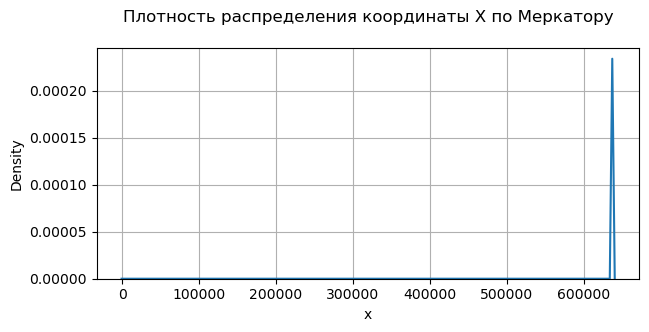

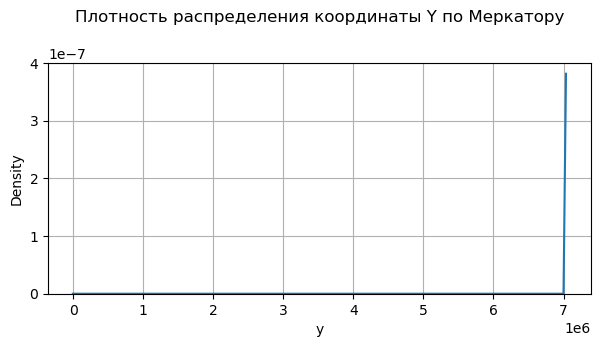

In [54]:
plt.figure(figsize = (7,3))
sns.kdeplot(data = telemetry,
            x = 'x')
plt.title('Плотность распределения координаты X по Меркатору\n')
plt.grid(visible = True)
plt.show()


plt.figure(figsize = (7,3))
sns.kdeplot(data = telemetry,
            x = 'y')
plt.title('Плотность распределения координаты Y по Меркатору\n')
plt.grid(visible = True)
plt.show()

Уберем выбросы координаты X и строим scatterplot расположения самосвалов

Text(0.5, 1.0, 'Карта передвижений всех самосвалов по карьеру\n')

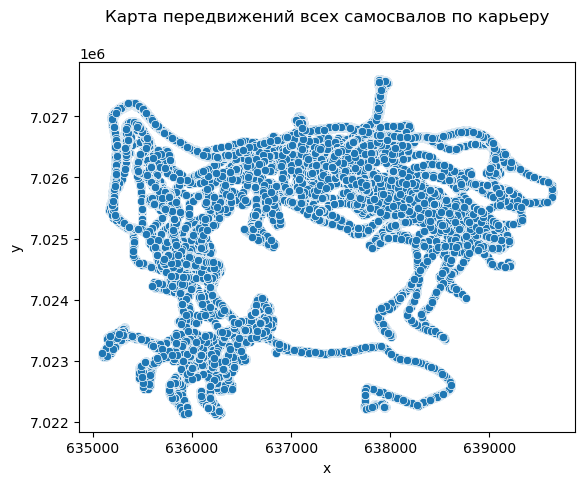

In [ ]:
telemetry_1 = telemetry[telemetry['x'] != 0]
sns.scatterplot(data = telemetry_1,
                x = 'x',
                y = 'y')
plt.title('Карта передвижений всех самосвалов по карьеру\n')

<a id = 'задание1_2'></a>

##### Обнаружить самосвал(ы), для которых всё ещё есть проблемы с координатами (обозначить их идентификаторы)

<a id = 'задание1_3'></a>

##### Понять, по какому параметру можно избавиться от этих выбросов по координатам, и сделать чистку

[к оглавлению](#title) 


In [ ]:
telemetry_1['x'].describe()

count    426312.000000
mean     637325.723577
std        1046.245947
min      635087.662312
25%      636595.910597
50%      637670.325284
75%      637887.905533
max      639639.257576
Name: x, dtype: float64

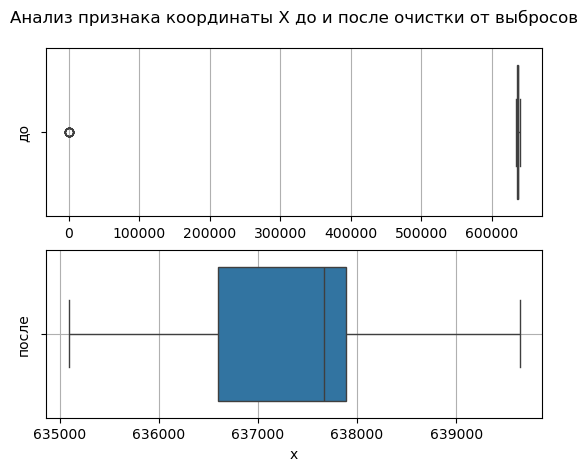

In [ ]:
fig, (ax_1,ax_2) = plt.subplots(2,
                                gridspec_kw = {'height_ratios':(.5, .5)})

ax_1 = plt.subplot(2,1,1)
sns.boxplot(data = telemetry,
            x = 'x',
            ax = ax_1)
plt.title('Анализ признака координаты X до и после очистки от выбросов\n')
plt.xlabel('\n')
plt.ylabel('до')
plt.grid(axis = 'x')


ax_2 = plt.subplot(2,1,2)
sns.boxplot(data = telemetry_1,
             x = 'x',
             ax = ax_2)
plt.ylabel('после')
plt.grid()

В новом фрейме (после отсеивания выбросов x координаты) адекватные статистические критерии (анализ boxplot) --> рассмотрим координату Y

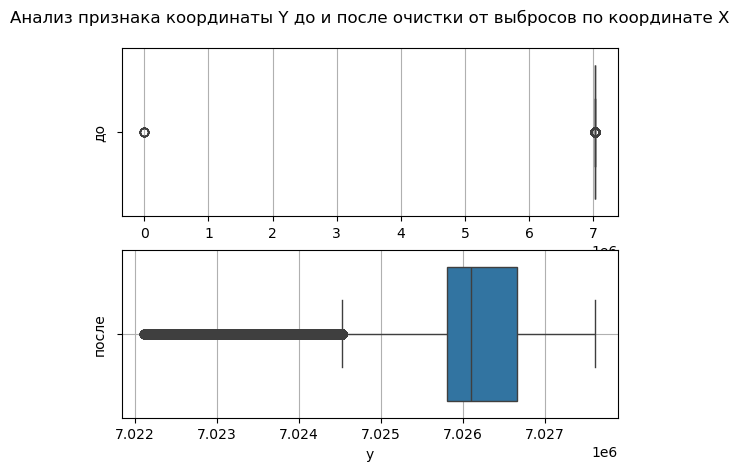

In [ ]:
fig, (ax_1,ax_2) = plt.subplots(2,
                                gridspec_kw = {'height_ratios':(.5, .5)})

ax_1 = plt.subplot(2,1,1)
sns.boxplot(data = telemetry,
            x = 'y',
            ax = ax_1)
plt.title('Анализ признака координаты Y до и после очистки от выбросов по координате X\n')
plt.xlabel('\n')
plt.ylabel('до')
plt.grid(axis = 'x')


ax_2 = plt.subplot(2,1,2)
sns.boxplot(data = telemetry_1,
             x = 'y',
             ax = ax_2)
plt.ylabel('после')
plt.grid()

Text(0.5, 1.0, 'Карта карьера после минимальной очитски')

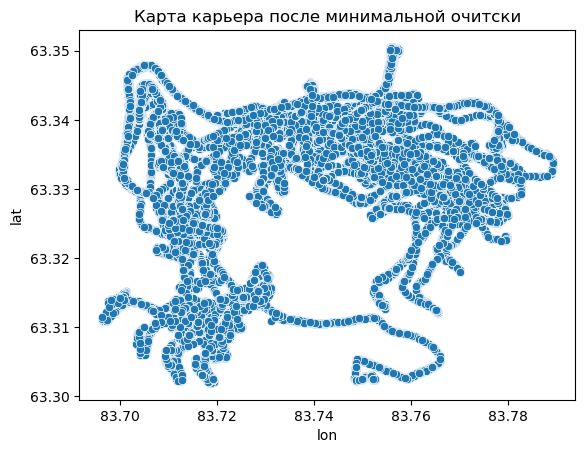

In [ ]:
sns.scatterplot(data = telemetry_1,
                x = 'lon',
                y = 'lat')
plt.title('Карта карьера после минимальной очитски')

ВНИМАНИЕ ! Хоть boxplot график и показывает числовые выбросы координаты Y, они не являются таковыми (scatter график пока выглядит приемлимо)

In [ ]:
telemetry[['x', 'y']].describe().round(2), telemetry_1[['x', 'y']].describe().round(2)

(               x           y
 count  426322.00   426322.00
 mean   637310.77  7025849.03
 std      3259.15    34042.31
 min         0.00        0.00
 25%    636595.91  7025805.66
 50%    637670.31  7026093.64
 75%    637887.90  7026658.80
 max    639639.26  7027611.32,
                x           y
 count  426312.00   426312.00
 mean   637325.72  7026013.84
 std      1046.25      989.46
 min    635087.66  7022117.76
 25%    636595.91  7025805.67
 50%    637670.33  7026093.71
 75%    637887.91  7026658.81
 max    639639.26  7027611.32)

Статистические показатели и по признаку координата X и по признаку координата Y в норме после отброса нулевыз координат X (у этих же образцов были нулевые координаты Y)

---

Посмотрим на траектории движения самосвалов поотдельности

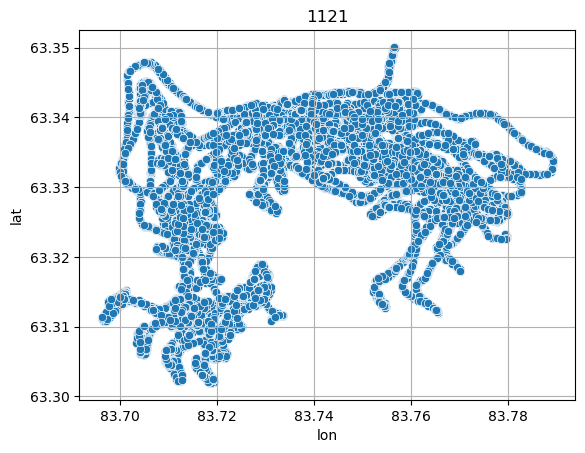

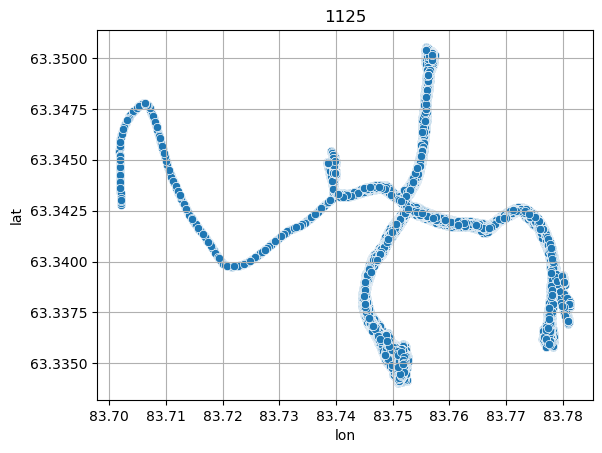

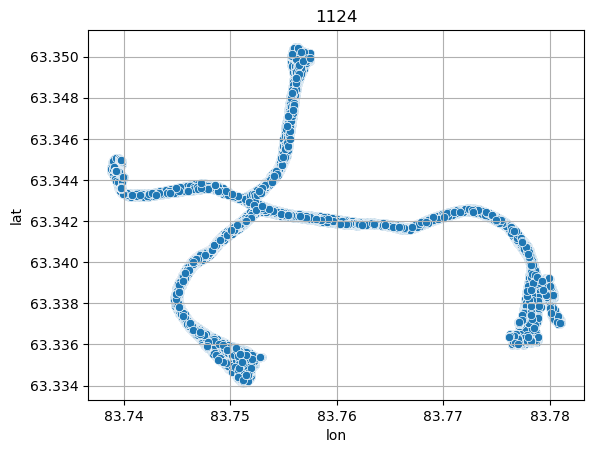

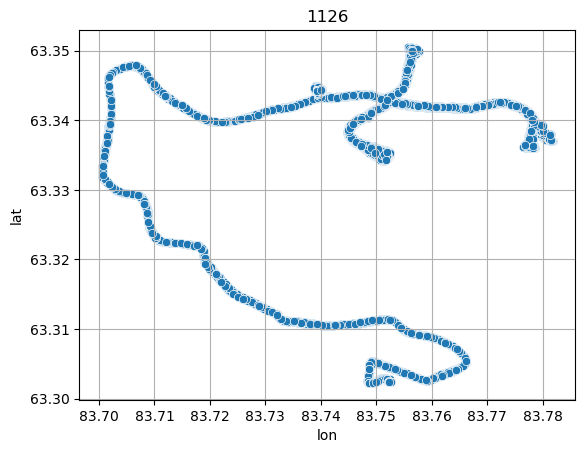

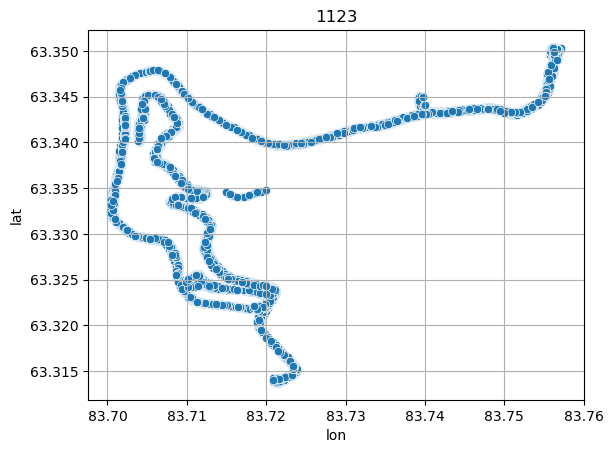

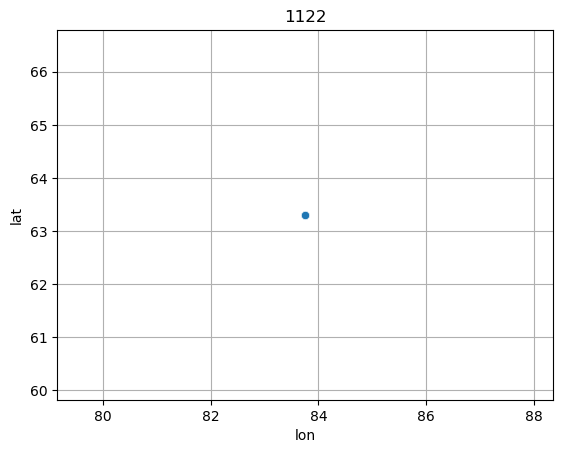

In [ ]:
for id in telemetry_1['objectid'].unique():
    id_data = telemetry_1[telemetry_1['objectid'] == id]
    sns.scatterplot(data = id_data,
                    x = 'lon',
                    y = 'lat')
    plt.grid()
    plt.title(id)
    plt.show()

- у самосвала 1122 вообще нет движения
- у самосвала 1123 есть странная кусочная траектория (возможно было прерывание GPS или что-то подобное, их мало, поэтому тоже в очистку)

---

Пробуем чистить

In [ ]:
telemetry_1 = telemetry_1[telemetry_1['objectid'] != 1122]

Text(0.5, 1.0, 'Выявление странных координат у самосвала 1123 (красные --> странные: их 40 штук)\n')

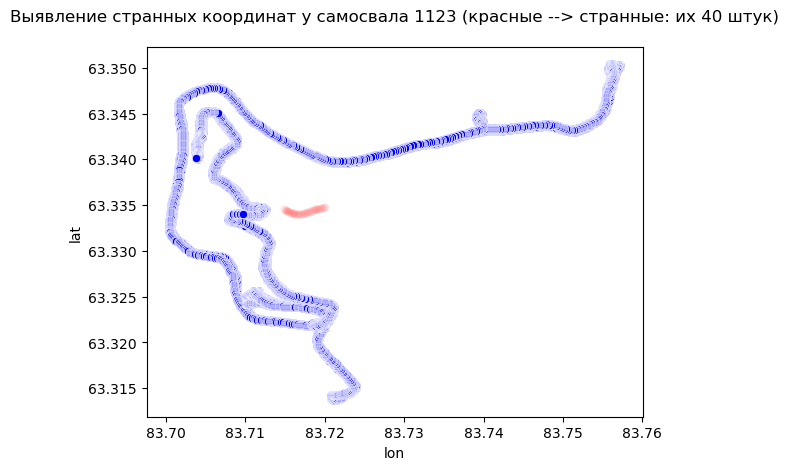

In [ ]:
proba = telemetry_1[telemetry_1['objectid'] == 1123].sort_values(by = 'time')
proba1 = proba[(proba['lat'] <= 63.335) & (proba['lat'] >= 63.3325) & (proba['lon'] <= 83.72) & (proba['lon'] >= 83.714)]
sns.scatterplot(data = proba[~proba.index.isin(proba1.index)],
                x = 'lon',
                y = 'lat',
                color = 'blue')
sns.scatterplot(data = proba1,
                x = 'lon',
                y = 'lat',
                color = 'red',
                alpha = 0.07)
plt.title('Выявление странных координат у самосвала 1123 (красные --> странные: их {} штук)\n'.format(len(proba1)))

Их действительно мало - 40 образцов --> удалим

In [ ]:
telemetry_2 = telemetry_1[~telemetry_1.index.isin(proba1.index)]
print('Длина сета до очстки от странных координат самосвала 1123 -- {} и после -- {}, разница = {}'.format(
    len(telemetry_1),
    len(telemetry_2),
    len(telemetry_1) - len(telemetry_2)
))

Длина сета до очстки от странных координат самосвала 1123 -- 425960 и после -- 425920, разница = 40


Сохраним очищенный датасет, чтобы не грузить оперативку о обновим ядро юпитера

In [ ]:
telemetry_2.to_csv('data.csv', index = False)

In [ ]:
data = pd.read_csv('data.csv')
data.head()

objectid                              time        lat        lon     speed  \
0      1121  2023-11-08 05:31:31.309000+07:00  63.328824  83.727988   3.00394   
1      1125         2023-11-08 03:21:39+07:00  63.334962  83.751046   0.00000   
2      1124         2023-11-08 19:20:55+07:00  63.343592  83.739678   4.20000   
3      1124         2023-11-08 14:16:39+07:00  63.343290  83.751773  16.80000   
4      1121  2023-11-08 11:09:49.347000+07:00  63.331924  83.765388   0.00000   

   height  fuel_cons  engine_speed   hdop  DQ_vertical_bump  \
0   195.7     390.00           NaN  99.99                 0   
1   280.0       0.00         0.000   8.00                 0   
2   228.0      66.85       778.000   5.00                 0   
3   278.0       2.45       743.375   6.00                 0   
4    70.9      17.00           NaN  99.99                 0   

   accelerator_position  fuel_tank_level  weight_dynamic     tripid  weight  \
0                     0             60.0           216.0  1003671.0   215.0   
1                     0              NaN             NaN  1003657.0   216.0   
2                     0              NaN             NaN  1003798.0   217.0   
3                     0              NaN             NaN  1003749.0   209.0   
4                     0             38.0             0.0  1003728.0   204.0   

   driverid  w_fl              x             y  
0    2891.0     1  636592.202274  7.025133e+06  
1    2887.0     0  637716.857273  7.025866e+06  
2    2875.0     0  637106.943106  7.026803e+06  
3    2875.0     0  637713.403209  7.026795e+06  
4    2894.0     0  638449.084136  7.025559e+06

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425920 entries, 0 to 425919
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   objectid              425920 non-null  int64  
 1   time                  425920 non-null  object 
 2   lat                   425920 non-null  float64
 3   lon                   425920 non-null  float64
 4   speed                 425920 non-null  float64
 5   height                425920 non-null  float64
 6   fuel_cons             425920 non-null  float64
 7   engine_speed          259203 non-null  float64
 8   hdop                  425920 non-null  float64
 9   DQ_vertical_bump      425920 non-null  int64  
 10  accelerator_position  425920 non-null  int64  
 11  fuel_tank_level       166717 non-null  float64
 12  weight_dynamic        166717 non-null  float64
 13  tripid                425317 non-null  float64
 14  weight                425317 non-null  float64
 15  

<a id = 'задание1_4'></a>

##### Нарисовать корректную карту карьера (если удалость определить, как сделать чистку)

[к оглавлению](#title) 

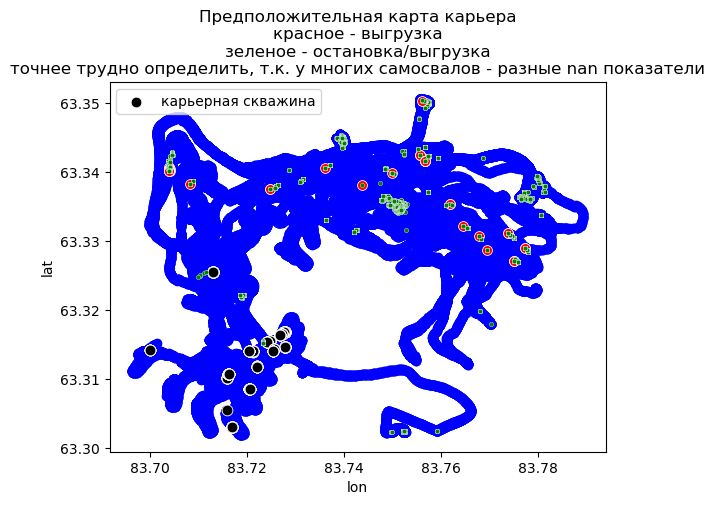

In [ ]:
def map_plotting():    # пишим функцию построения карты --> дальше будем ею пользоваться  
    plt.scatter(
        x = data['lon'],
        y = data['lat'],
        color = 'blue')

    for id in data['objectid'].unique():    
        df = data[data['objectid'] == id].sort_values(by = 'time')
        df['shift_weight_dynamic'] = df['weight_dynamic'].shift(-3)
        sns.scatterplot(data = df[(df['speed'] == 0) & (df['height'] < 0)],
                        x = 'lon',
                        y = 'lat',
                        color = 'black',
                        s = 60,
                        label = 'карьерная скважина')
        sns.scatterplot(data = df[(df['speed'] == 0) &
                                (df['height'] >= 0) & (df['weight_dynamic'] > df['shift_weight_dynamic']) &
                                (df['weight_dynamic'] != 0)],
                        x = 'lon',
                        y = 'lat',
                        color = 'red',
                        s = 50)
        sns.scatterplot(data = df[(df['speed'] == 0) &
                                (df['height'] >= 0)],
                        x = 'lon',
                        y = 'lat',
                        color = 'green',
                        s = 10)
        plt.title('Предположительная карта карьера\nкрасное - выгрузка\nзеленое - остановка/выгрузка\nточнее трудно определить, т.к. у многих самосвалов - разные nan показатели')
        plt.legend()

map_plotting()

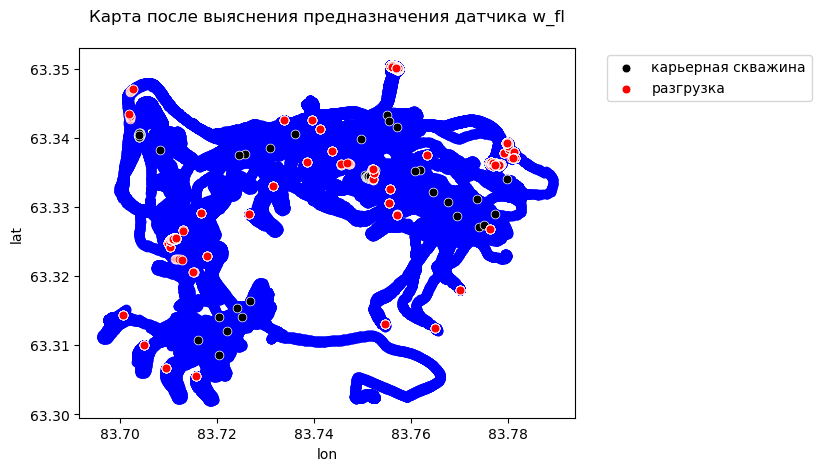

In [ ]:
def map_plotting():    
    plt.scatter(
            x = data['lon'],
            y = data['lat'],
            color = 'blue'
            )
    trip_scatter_skvazina = pd.DataFrame()
    trip_scatter_razgruzka = pd.DataFrame()
    for tripid in data['tripid'].unique():
        trip = data[data['tripid'] == tripid][['time', 'lon', 'lat', 'w_fl']].sort_values(by = 'time')
        trip['w_fl_shift'] = trip['w_fl'].shift(-1)
        trip_skvazina = trip[(trip['w_fl'] == 0) & (trip['w_fl_shift'] == 1)]
        trip_razgruzka = pd.DataFrame(trip.iloc[:10,:])
        trip_scatter_skvazina = pd.concat([trip_scatter_skvazina, trip_skvazina], axis = 0)
        trip_scatter_razgruzka = pd.concat([trip_scatter_razgruzka, trip_razgruzka], axis = 0)    


    sns.scatterplot(data = trip_scatter_skvazina,
                        x = 'lon',
                        y = 'lat',
                        color = 'black',
                        s = 40,
                        label = 'карьерная скважина')   

    sns.scatterplot(data = trip_scatter_razgruzka,
                        x = 'lon',
                        y = 'lat',
                        color = 'red',
                        s = 40,
                        label = 'разгрузка')
    plt.title('Карта после выяснения предназначения датчика w_fl\n')
    plt.legend(bbox_to_anchor=(1.05, 1))

map_plotting()

<a id = 'задание1_5'></a>

##### При необходимости, произвести чистку по другим колонкам (препроцессинг для дальнейшего обучения модели)

[к оглавлению](#title) 

In [ ]:
data.columns

Index(['objectid', 'time', 'lat', 'lon', 'speed', 'height', 'fuel_cons',
       'engine_speed', 'hdop', 'DQ_vertical_bump', 'accelerator_position',
       'fuel_tank_level', 'weight_dynamic', 'tripid', 'weight', 'driverid',
       'w_fl', 'x', 'y'],
      dtype='object')

In [ ]:
priznak_list =\
          ['speed',
           'height',
           'fuel_cons',
           'engine_speed',
           'hdop',
           'DQ_vertical_bump',
           'accelerator_position',
           'fuel_tank_level',
           'weight_dynamic',
           'tripid',
           'weight',
           'driverid',
           'w_fl']

def plot_stat_priznak(priznak):
    df = data[priznak]
    empty = df.isnull().sum()
    fig, (ax_1,ax_2) = plt.subplots(2,
                                    gridspec_kw = {'height_ratios':(.15, .85)})


    ax_1 = plt.subplot(2,1,1)
    sns.boxplot(
                x = df,
                ax = ax_1)
    plt.title('Анализ признака {}\nДоля пустых значений: {}'.format(priznak, (empty / len(df)).round(5)))
    plt.xlabel('\n')
    plt.grid(axis = 'x')


    ax_2 = plt.subplot(2,1,2)
    sns.histplot(data = df,
                kde = True,
                ax = ax_2)
    plt.grid()
    print(df.describe())

##### Speed

count    425920.000000
mean         13.199333
std          12.540507
min           0.000000
25%           0.577824
50%          11.549100
75%          24.400000
max          50.500000
Name: speed, dtype: float64


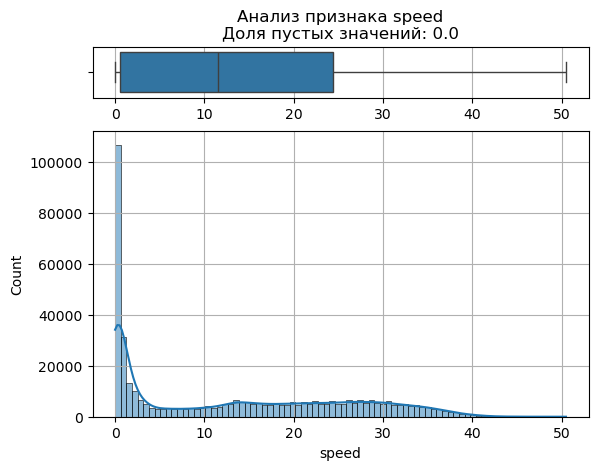

In [ ]:
plot_stat_priznak('speed')

Норма.

- это будущий таргет для регрессии (трогать не стоит)
- нет пустых значений
- много единичных значений (speed > 40) - это не проблема для задачи регрессии

##### height

count    425920.000000
mean        190.935612
std         123.985726
min        -433.400000
25%         130.200000
50%         255.000000
75%         271.000000
max         332.000000
Name: height, dtype: float64


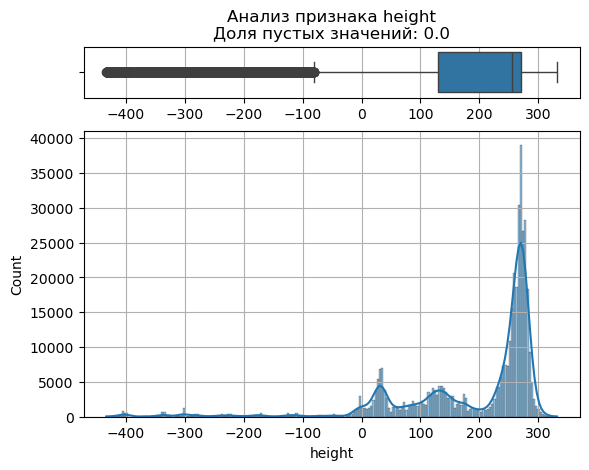

In [ ]:
plot_stat_priznak('height')

Норма.

- пустых значений нет
- есть выбросы, но это нормально (самосвалы малое время проводят в самом низу)

##### fuel_cons

count    425920.000000
mean        100.834843
std         128.829492
min           0.000000
25%          17.000000
50%          35.400000
75%         146.000000
max         441.900000
Name: fuel_cons, dtype: float64


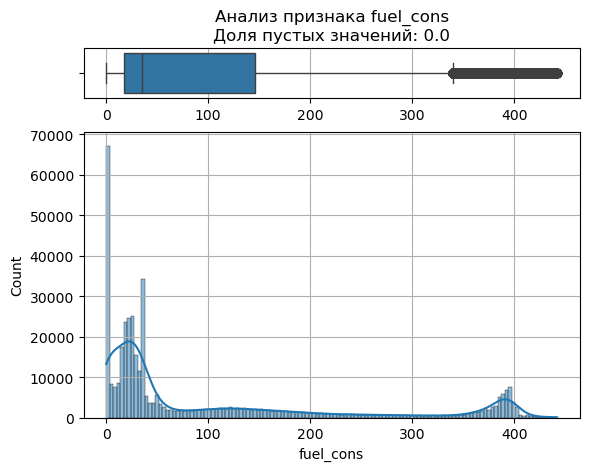

In [ ]:
plot_stat_priznak('fuel_cons')

In [ ]:
(len(data[data['fuel_cons']>= 340]) / len(data))

0.12552826821938393

Норма.

- пустых значений нет
- есть выбросы (12,5%)

##### engine_speed

count    259203.000000
mean       1099.331509
std         354.426768
min           0.000000
25%         977.000000
50%        1124.750000
75%        1293.000000
max        1874.000000
Name: engine_speed, dtype: float64


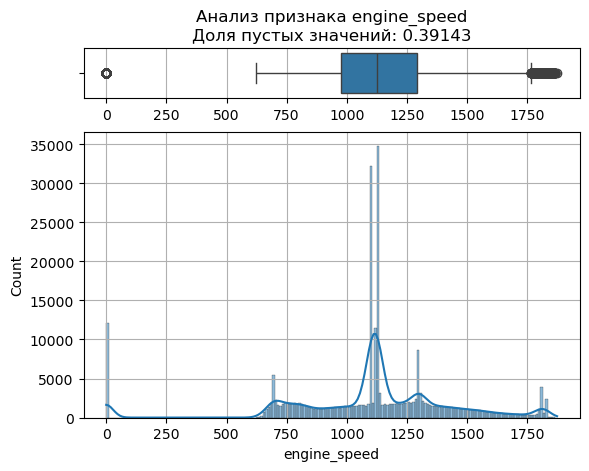

In [ ]:
plot_stat_priznak('engine_speed')

In [ ]:
corr_sravnenie = \
pd.concat([data[data['engine_speed'] > 1750][priznak_list].corr()['engine_speed'],
           data[(data['engine_speed'] >= 500) & (data['engine_speed'] <= 1750)][priznak_list].corr()['engine_speed']],
           axis = 1)
corr_sravnenie.columns = ['Коэфф. corr engine_speed values > 1750',  'Коэфф. corr engine_speed , без выбросов']
corr_sravnenie

Коэфф. corr engine_speed values > 1750  \
speed                                               0.099544   
height                                             -0.079972   
fuel_cons                                           0.174988   
engine_speed                                        1.000000   
hdop                                                0.049098   
DQ_vertical_bump                                         NaN   
accelerator_position                                     NaN   
fuel_tank_level                                          NaN   
weight_dynamic                                           NaN   
tripid                                              0.051395   
weight                                              0.047658   
driverid                                            0.303249   
w_fl                                                0.060853   

                      Коэфф. corr engine_speed , без выбросов  
speed                                                0.326578  
height                                               0.020421  
fuel_cons                                            0.672366  
engine_speed                                         1.000000  
hdop                                                 0.006722  
DQ_vertical_bump                                          NaN  
accelerator_position                                      NaN  
fuel_tank_level                                           NaN  
weight_dynamic                                            NaN  
tripid                                               0.047327  
weight                                               0.007509  
driverid                                             0.002094  
w_fl                                                 0.155477

objectid      lat      lon    speed   height  fuel_cons  engine_speed  \
count   9624.00  9624.00  9624.00  9624.00  9624.00    9624.00       9624.00   
mean    1125.07    63.34    83.75    25.23   264.58     381.96       1807.97   
std        0.84     0.00     0.01     7.25    29.75      45.30         19.53   
min     1124.00    63.30    83.70     0.00    85.00       0.00       1750.12   
25%     1124.00    63.34    83.75    20.50   264.00     369.55       1803.50   
50%     1125.00    63.34    83.75    25.00   272.00     390.15       1810.00   
75%     1126.00    63.34    83.75    30.90   277.00     406.08       1825.00   
max     1126.00    63.35    83.78    42.40   307.00     441.90       1874.00   

          hdop  DQ_vertical_bump  accelerator_position  fuel_tank_level  \
count  9624.00            9624.0                9624.0              0.0   
mean      7.60               0.0                   0.0              NaN   
std       2.03               0.0                   0.0              NaN   
min       5.00               0.0                   0.0              NaN   
25%       6.00               0.0                   0.0              NaN   
50%       7.00               0.0                   0.0              NaN   
75%       8.00               0.0                   0.0              NaN   
max      36.00               0.0                   0.0              NaN   

       weight_dynamic      tripid   weight  driverid     w_fl          x  \
count             0.0     9623.00  9623.00   9623.00  9624.00    9624.00   
mean              NaN  1003746.07   216.01   2892.82     0.77  637580.63   
std               NaN       59.50     6.88     13.53     0.42     540.47   
min               NaN  1003627.00   199.00   2875.00     0.00  635193.71   
25%               NaN  1003696.00   211.00   2884.00     1.00  637428.91   
50%               NaN  1003755.00   216.00   2889.00     1.00  637472.05   
75%               NaN  1003800.00   221.00   2909.00     1.00  637740.12   
max               NaN  1003840.00   231.00   2909.00     1.00  639227.27   

                y  
count     9624.00  
mean   7026447.47  
std        469.27  
min    7022388.78  
25%    7026343.28  
50%    7026418.73  
75%    7026656.09  
max    7027608.41

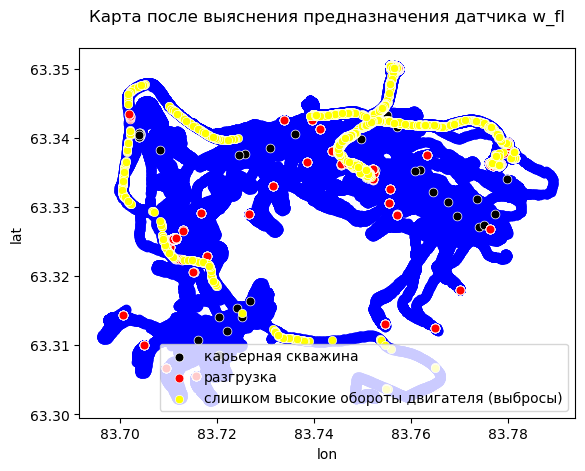

In [ ]:
map_plotting()
sns.scatterplot(data = data[data['engine_speed'] > 1750],
                x = 'lon',
                y = 'lat',
                color = 'yellow',
                label = 'слишком высокие обороты двигателя (выбросы)')
data[data['engine_speed'] > 1750].describe().round(2)

In [ ]:
data['engine_speed'].isnull().sum()

166717

In [ ]:
data['engine_speed'] = data['engine_speed'].fillna(data['engine_speed'].mean())
data['engine_speed'].isnull().sum()

0

- мнгого пустых значений --> заполняем среднем
- очень странная корреляция фрейма (1 колонка)
    - скорость не всегда зависит от оборотов (например пробуксовка)
    - увеличилась весовая зависимость (что нормально)
    - !!! не понятно почему у больших оборотов меньшая связь с расходом топлива чем у 'очищенного' фрейма (разница в 4 раза). Причем это точно две зависимые величины
    - оставим так, возможно просто сделаем отдельный датасет без таких выбросов и проверим метрику модели

##### hdop

снижение точности в горизонтальной плоскости. Чем меньше данный коэффициент, тем выше точность определения геопозиции

count    425920.000000
mean         23.932666
std          36.901803
min           0.610000
25%           6.000000
50%           7.000000
75%          10.000000
max          99.990000
Name: hdop, dtype: float64


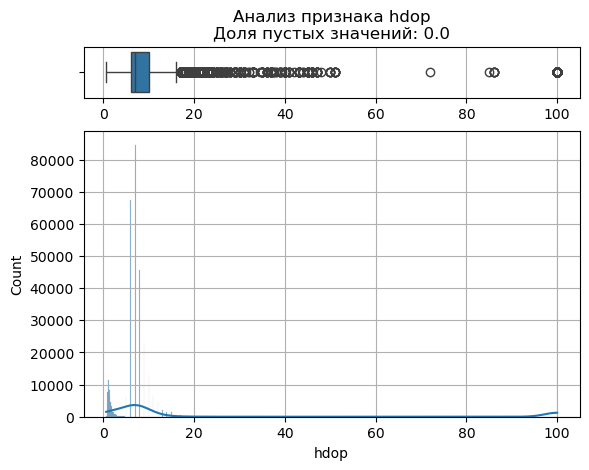

In [ ]:
plot_stat_priznak('hdop')

In [ ]:
data[data['hdop'] >= 20]['hdop'].value_counts().head()

hdop
99.99    80711
20.00      194
22.00      189
23.00      134
24.00      130
Name: count, dtype: int64

- нет пустых значений
- есть большое кол-во значений 99.99
- признак определяет точность геопозиции --> возможно вообще не нуже для регрессии относительно speed
- пока оставляем , позже посмотрим на корреляцию

##### DQ_vertical_bump

count    425920.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: DQ_vertical_bump, dtype: float64


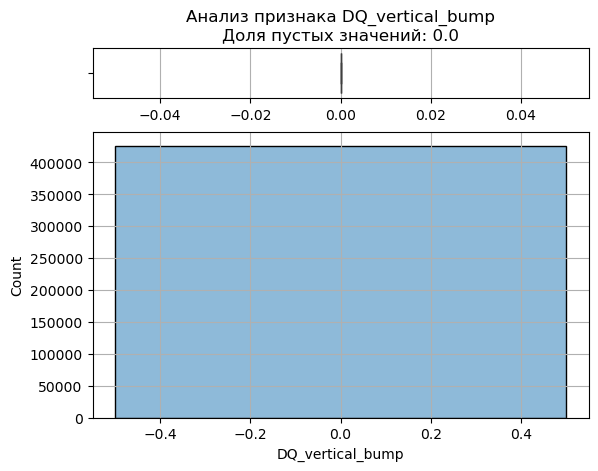

In [ ]:
plot_stat_priznak('DQ_vertical_bump')

In [ ]:
data['DQ_vertical_bump'].unique()

array([0], dtype=int64)

вообще нет никаких данных ---> все по нулям

##### accelerator_position

count    425920.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: accelerator_position, dtype: float64


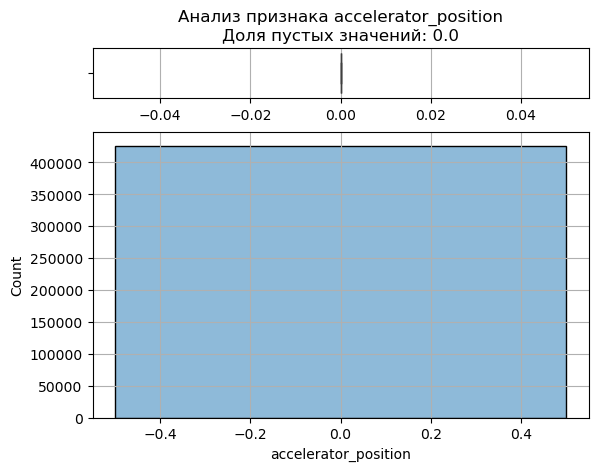

In [ ]:
plot_stat_priznak('accelerator_position')

In [ ]:
data['accelerator_position'].unique()

array([0], dtype=int64)

все по нулям

##### fuel_tank_level

count    166717.000000
mean         47.990865
std          14.914805
min          12.000000
25%          36.000000
50%          47.000000
75%          59.000000
max         100.000000
Name: fuel_tank_level, dtype: float64


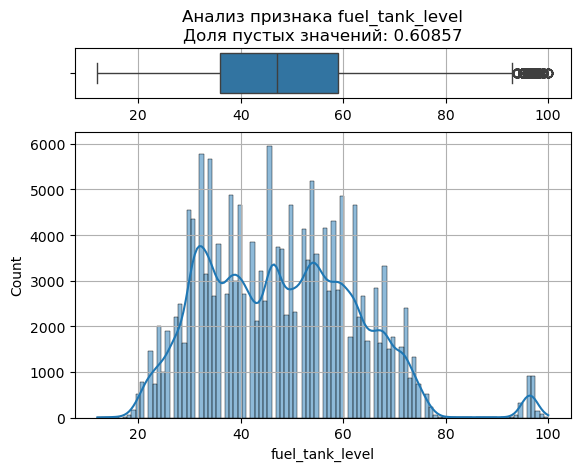

In [ ]:
plot_stat_priznak('fuel_tank_level')

<Axes: title={'center': 'Карта после выяснения предназначения датчика w_fl\n'}, xlabel='lon', ylabel='lat'>

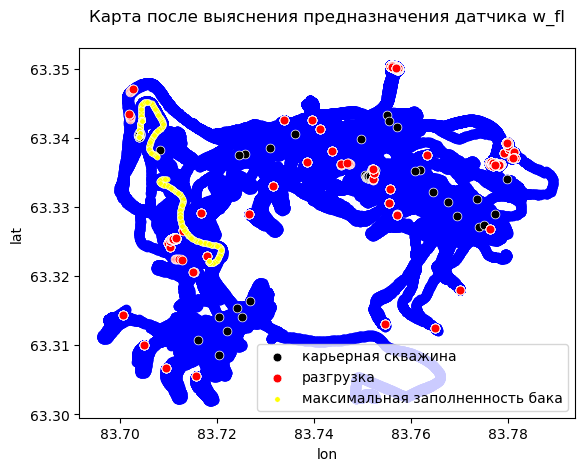

In [ ]:
map_plotting()
sns.scatterplot(data = data[data['fuel_tank_level'] >= 90],
                    x = 'lon',
                    y = 'lat',
                    s = 15,
                    color = 'yellow',
                    label = 'максимальная заполненность бака')

похоже, что датчик почти полного бака отражается только у одного самосвала, проверим

In [ ]:
data[data['fuel_tank_level'] >= 90]['objectid'].unique()

array([1123], dtype=int64)

In [ ]:
data.groupby('objectid')['fuel_tank_level'].count()

objectid
1121    86119
1123    80598
1124        0
1125        0
1126        0
Name: fuel_tank_level, dtype: int64

In [ ]:
# сколько у каждого самосвала пустых значений по признаку fuel_tank_level
data.set_index('objectid')['fuel_tank_level'].isnull().reset_index().groupby('objectid')['fuel_tank_level'].sum()

objectid
1121        0
1123        0
1124    86401
1125    86401
1126    86401
Name: fuel_tank_level, dtype: int64

In [ ]:
data['fuel_tank_level'] = data['fuel_tank_level'].fillna(data['fuel_tank_level'].mean())

In [ ]:
data['fuel_tank_level'].isnull().sum()

0

- есть немного верхних выбросов и только у самосвала 1123 (полный бак/почти полный (90-100%) был только у него)
- много пустых значений
- заполнять их по рекомендации (предыдущим определенным значением) нет смысла, т.к. у самосвалов 1121 / 1123 полностью заполнены эти значения, а у оставшихся самовалов они вообще пустые
- т.к. пустых значений слишком много (61%) --> заполним средним

##### weight_dynamic

count    166717.00000
mean         96.30526
std         103.16655
min           0.00000
25%           0.00000
50%           2.00000
75%         210.00000
max         249.00000
Name: weight_dynamic, dtype: float64


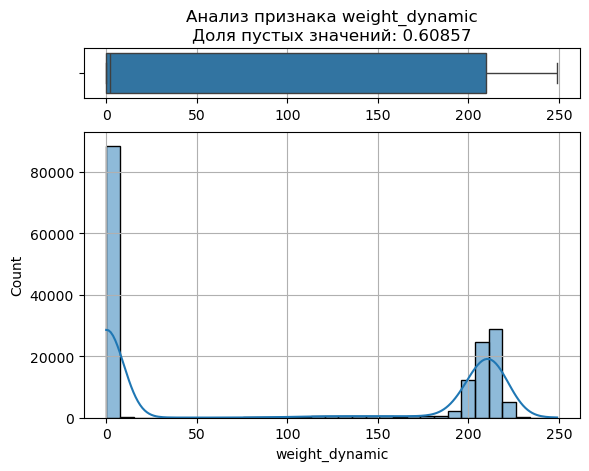

In [ ]:
plot_stat_priznak('weight_dynamic')

In [ ]:
data.groupby('objectid')['weight_dynamic'].count()

objectid
1121    86119
1123    80598
1124        0
1125        0
1126        0
Name: weight_dynamic, dtype: int64

In [ ]:
# сколько у каждого самосвала пустых значений по признаку weight_dynamic
data.set_index('objectid')['weight_dynamic'].isnull().reset_index().groupby('objectid')['weight_dynamic'].sum()

objectid
1121        0
1123        0
1124    86401
1125    86401
1126    86401
Name: weight_dynamic, dtype: int64

In [ ]:
data['weight_dynamic'] = data['weight_dynamic'].fillna(data['weight_dynamic'].mean())
data['weight_dynamic'].isnull().sum()

0

- датчик weight_dynamic работает только у 1121 / 1123 самосвалов
- причем пустые значения у работающих датчиков отсутствуют
- заполнять их по рекомендации (предыдущим определенным значением) нет смысла, т.к. у самосвалов 1121 / 1123 полностью заполнены эти значения, а у оставшихся самовалов они вообще пустые
- т.к. пустых значений слишком много (61%) --> заполним средним

##### tripid

count    4.253170e+05
mean     1.003731e+06
std      6.050562e+01
min      1.003626e+06
25%      1.003678e+06
50%      1.003731e+06
75%      1.003780e+06
max      1.003841e+06
Name: tripid, dtype: float64


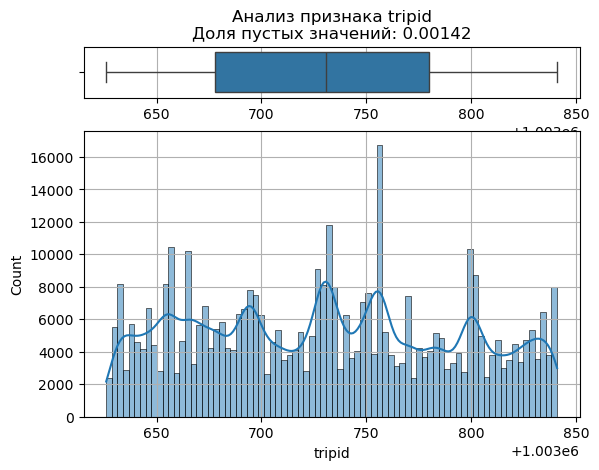

In [ ]:
plot_stat_priznak('tripid')

In [ ]:
data[data['tripid'].isnull()].describe().round(1)

objectid    lat    lon  speed  height  fuel_cons  engine_speed   hdop  \
count     603.0  603.0  603.0  603.0   603.0      603.0         603.0  603.0   
mean     1124.8   63.3   83.8   22.1   276.2       82.7        1118.0    7.5   
std         0.4    0.0    0.0   13.2     6.9       82.7         271.0    0.9   
min      1124.0   63.3   83.7    0.0   259.0        1.2         648.5    6.0   
25%      1125.0   63.3   83.8   12.3   271.0        4.3         849.9    7.0   
50%      1125.0   63.3   83.8   26.1   277.0       54.4        1147.6    7.0   
75%      1125.0   63.3   83.8   32.8   281.0      141.7        1325.5    8.0   
max      1125.0   63.3   83.8   42.0   293.0      388.6        1800.1   12.0   

       DQ_vertical_bump  accelerator_position  fuel_tank_level  \
count             603.0                 603.0            603.0   
mean                0.0                   0.0             48.0   
std                 0.0                   0.0              0.0   
min                 0.0                   0.0             48.0   
25%                 0.0                   0.0             48.0   
50%                 0.0                   0.0             48.0   
75%                 0.0                   0.0             48.0   
max                 0.0                   0.0             48.0   

       weight_dynamic  tripid  weight  driverid   w_fl         x          y  
count           603.0     0.0     0.0       0.0  603.0     603.0      603.0  
mean             96.3     NaN     NaN       NaN    0.0  638323.1  7026317.2  
std               0.0     NaN     NaN       NaN    0.0     654.5      312.1  
min              96.3     NaN     NaN       NaN    0.0  637399.5  7025849.1  
25%              96.3     NaN     NaN       NaN    0.0  637742.6  7026045.1  
50%              96.3     NaN     NaN       NaN    0.0  638263.5  7026300.6  
75%              96.3     NaN     NaN       NaN    0.0  639012.5  7026656.9  
max              96.3     NaN     NaN       NaN    0.0  639211.9  7026760.4

In [ ]:
tripid_index = data[data['tripid'].isnull()].index
weightg_index = data[data['weight'].isnull()].index
driverid_index = data[data['driverid'].isnull()].index

print(tripid_index[~tripid_index.isin(weightg_index)])
print(tripid_index[~tripid_index.isin(driverid_index)])
print(weightg_index[~weightg_index.isin(driverid_index)])

Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')


<Axes: title={'center': 'Карта после выяснения предназначения датчика w_fl\n'}, xlabel='lon', ylabel='lat'>

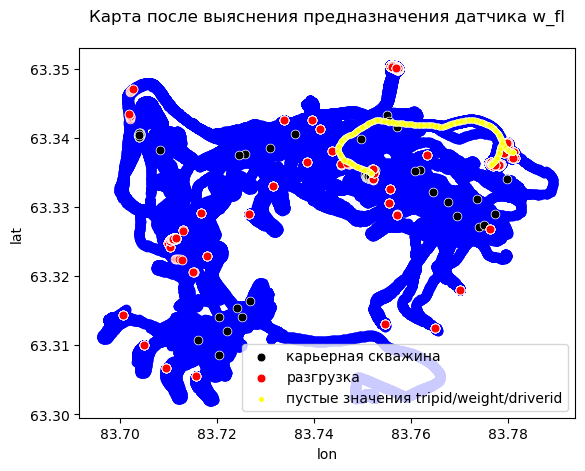

In [ ]:
map_plotting()
sns.scatterplot(data = data[data['tripid'].isnull()],
                x = 'lon',
                y = 'lat',
                s = 15,
                color = 'yellow',
                label = 'пустые значения tripid/weight/driverid')

In [ ]:
probnik = data[data['objectid'] == 1125].sort_values(by = 'time')
probnik_empty = probnik[probnik['tripid'].isnull()]
max_time = probnik_empty['time'].max()
min_time = probnik_empty['time'].min()

print('Максимальное время пустых датчиков самосвала 1125 tripid/weight/driverid: {}'.format(max_time))
print('Минимальное время пустых датчиков самосвала 1125 tripid/weight/driverid: {}'.format(min_time))

Максимальное время пустых датчиков самосвала 1125 tripid/weight/driverid: 2023-11-09 00:00:00+07:00
Минимальное время пустых датчиков самосвала 1125 tripid/weight/driverid: 2023-11-08 23:51:33+07:00


In [ ]:
probnik['tripid_shift'] = probnik['tripid'].shift(2)
probnik['weight_shift'] = probnik['weight'].shift(2)
probnik['weight_dynamic_shift'] = probnik['weight_dynamic'].shift(2)
probnik['driverid_shift'] = probnik['driverid'].shift(2)
probnik['time_shift'] = probnik['time'].shift(2)
probnik.loc[probnik_empty.index].head()

objectid                       time        lat        lon  speed  \
1370        1125  2023-11-08 23:51:33+07:00  63.337907  83.781191    0.7   
312905      1125  2023-11-08 23:51:34+07:00  63.337907  83.781188    0.9   
397631      1125  2023-11-08 23:51:35+07:00  63.337907  83.781184    0.9   
143240      1125  2023-11-08 23:51:36+07:00  63.337907  83.781183    0.3   
14052       1125  2023-11-08 23:51:37+07:00  63.337907  83.781179    0.1   

        height  fuel_cons  engine_speed  hdop  DQ_vertical_bump  ...  weight  \
1370     278.0       2.35       1050.75   7.0                 0  ...     NaN   
312905   277.0       2.20        964.00   7.0                 0  ...     NaN   
397631   277.0       2.15        884.25   6.0                 0  ...     NaN   
143240   277.0       2.20        808.25   7.0                 0  ...     NaN   
14052    277.0       2.20        735.50   7.0                 0  ...     NaN   

        driverid  w_fl              x             y  tripid_shift  \
1370         NaN     0  639210.970658  7.026259e+06     1003837.0   
312905       NaN     0  639210.820565  7.026259e+06     1003837.0   
397631       NaN     0  639210.620441  7.026259e+06           NaN   
143240       NaN     0  639210.570410  7.026259e+06           NaN   
14052        NaN     0  639210.370287  7.026259e+06           NaN   

        weight_shift  weight_dynamic_shift  driverid_shift  \
1370           214.0              96.30526          2889.0   
312905         214.0              96.30526          2889.0   
397631           NaN              96.30526             NaN   
143240           NaN              96.30526             NaN   
14052            NaN              96.30526             NaN   

                       time_shift  
1370    2023-11-08 23:51:31+07:00  
312905  2023-11-08 23:51:32+07:00  
397631  2023-11-08 23:51:33+07:00  
143240  2023-11-08 23:51:34+07:00  
14052   2023-11-08 23:51:35+07:00  

[5 rows x 24 columns]

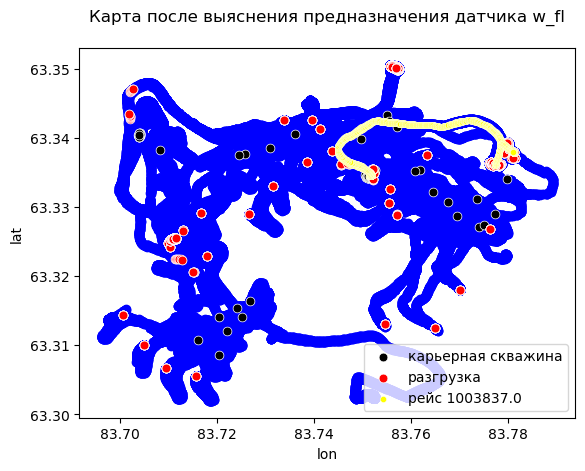

<Axes: title={'center': 'Карта после выяснения предназначения датчика w_fl\n'}, xlabel='lon', ylabel='lat'>

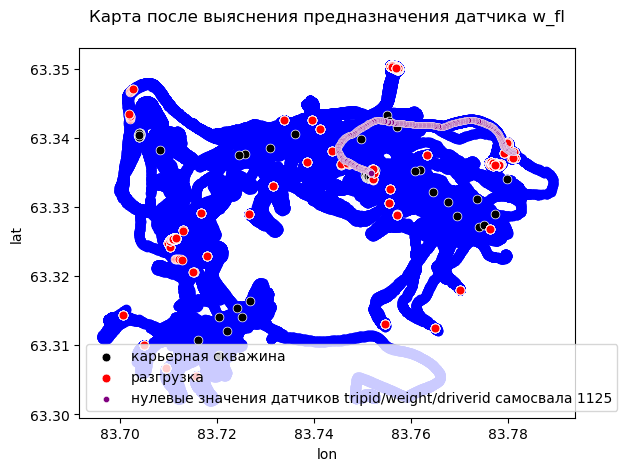

In [ ]:
map_plotting()
sns.scatterplot(data = probnik[(probnik['tripid'] == 1003837.0)],
                x = 'lon',
                y = 'lat',
                color = 'yellow',
                s = 20,
                label = 'рейс 1003837.0')
plt.show()


map_plotting()
sns.scatterplot(data = probnik[(probnik['tripid'].isnull())],
                x = 'lon',
                y = 'lat',
                color = 'purple',
                s = 20,
                label = 'нулевые значения датчиков tripid/weight/driverid самосвала 1125')

In [ ]:
data.loc[(data['objectid'] == 1125) & (data['tripid'].isnull()), 'tripid'] = 1003837.0
data.loc[(data['objectid'] == 1125) & (data['weight'].isnull()), 'weight'] = 214.0
data.loc[(data['objectid'] == 1125) & (data['driverid'].isnull()), 'driverid'] = 2889.0

In [ ]:
probnik = data[data['objectid'] == 1124].sort_values(by = 'time')
probnik_empty = probnik[probnik['tripid'].isnull()]
max_time = probnik_empty['time'].max()
min_time = probnik_empty['time'].min()

print('Максимальное время пустых датчиков самосвала 1124 tripid/weight/driverid: {}'.format(max_time))
print('Минимальное время пустых датчиков самосвала 1124 tripid/weight/driverid: {}'.format(min_time))

Максимальное время пустых датчиков самосвала 1124 tripid/weight/driverid: 2023-11-09 00:00:00+07:00
Минимальное время пустых датчиков самосвала 1124 tripid/weight/driverid: 2023-11-08 23:58:26+07:00


In [ ]:
probnik['tripid_shift'] = probnik['tripid'].shift(2)
probnik['weight_shift'] = probnik['weight'].shift(2)
probnik['weight_dynamic_shift'] = probnik['weight_dynamic'].shift(2)
probnik['driverid_shift'] = probnik['driverid'].shift(2)
probnik['time_shift'] = probnik['time'].shift(2)
probnik.loc[probnik_empty.index].head()

objectid                       time        lat        lon  speed  \
22861       1124  2023-11-08 23:58:26+07:00  63.336007  83.776493    3.8   
115869      1124  2023-11-08 23:58:27+07:00  63.336017  83.776499    3.8   
295925      1124  2023-11-08 23:58:28+07:00  63.336027  83.776511    3.5   
7163        1124  2023-11-08 23:58:29+07:00  63.336037  83.776524    3.5   
181522      1124  2023-11-08 23:58:30+07:00  63.336047  83.776529    2.2   

        height  fuel_cons  engine_speed  hdop  DQ_vertical_bump  ...  weight  \
22861    259.0       3.10       838.250   8.0                 0  ...     NaN   
115869   259.0       4.10       765.750   8.0                 0  ...     NaN   
295925   259.0      14.85       705.125   8.0                 0  ...     NaN   
7163     260.0      77.05       709.875   8.0                 0  ...     NaN   
181522   260.0      57.50       914.500   7.0                 0  ...     NaN   

        driverid  w_fl              x             y  tripid_shift  \
22861        NaN     0  638985.093677  7.026037e+06     1003838.0   
115869       NaN     0  638985.345628  7.026038e+06     1003838.0   
295925       NaN     0  638985.897784  7.026040e+06           NaN   
7163         NaN     0  638986.499973  7.026041e+06           NaN   
181522       NaN     0  638986.701888  7.026042e+06           NaN   

        weight_shift  weight_dynamic_shift  driverid_shift  \
22861          207.0              96.30526          2875.0   
115869         207.0              96.30526          2875.0   
295925           NaN              96.30526             NaN   
7163             NaN              96.30526             NaN   
181522           NaN              96.30526             NaN   

                       time_shift  
22861   2023-11-08 23:58:24+07:00  
115869  2023-11-08 23:58:25+07:00  
295925  2023-11-08 23:58:26+07:00  
7163    2023-11-08 23:58:27+07:00  
181522  2023-11-08 23:58:28+07:00  

[5 rows x 24 columns]

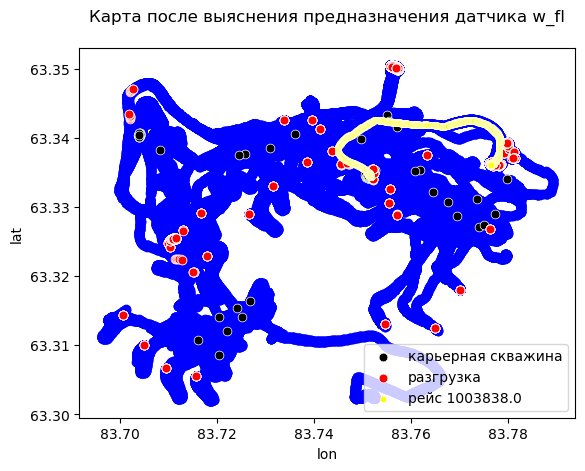

<Axes: title={'center': 'Карта после выяснения предназначения датчика w_fl\n'}, xlabel='lon', ylabel='lat'>

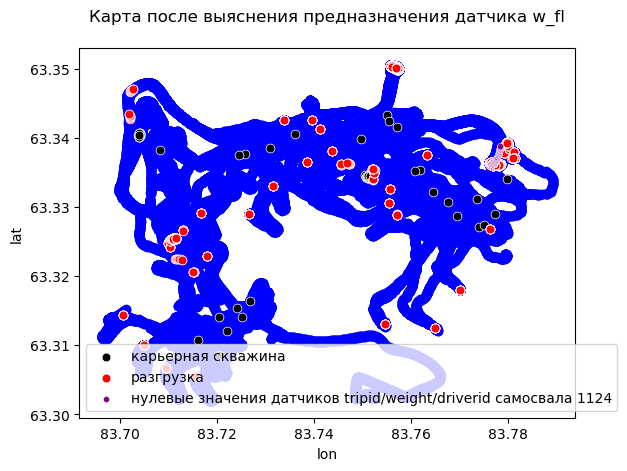

In [ ]:
map_plotting()
sns.scatterplot(data = probnik[(probnik['tripid'] == 1003838.0)],
                x = 'lon',
                y = 'lat',
                color = 'yellow',
                s = 20,
                label = 'рейс 1003838.0')
plt.show()


map_plotting()
sns.scatterplot(data = probnik[(probnik['tripid'].isnull())],
                x = 'lon',
                y = 'lat',
                color = 'purple',
                s = 20,
                label = 'нулевые значения датчиков tripid/weight/driverid самосвала 1124')

In [ ]:
data.loc[(data['objectid'] == 1124) & (data['tripid'].isnull()), 'tripid'] = 1003838.0
data.loc[(data['objectid'] == 1124) & (data['weight'].isnull()), 'weight'] = 207.0
data.loc[(data['objectid'] == 1124) & (data['driverid'].isnull()), 'driverid'] = 2875.0

In [ ]:
data[(data['objectid'] == 1124) & (data['tripid'].isnull())]

Empty DataFrame
Columns: [objectid, time, lat, lon, speed, height, fuel_cons, engine_speed, hdop, DQ_vertical_bump, accelerator_position, fuel_tank_level, weight_dynamic, tripid, weight, driverid, w_fl, x, y]
Index: []

Норма

##### weight

count    425920.000000
mean        213.705306
std           6.894590
min         195.000000
25%         210.000000
50%         214.000000
75%         219.000000
max         231.000000
Name: weight, dtype: float64


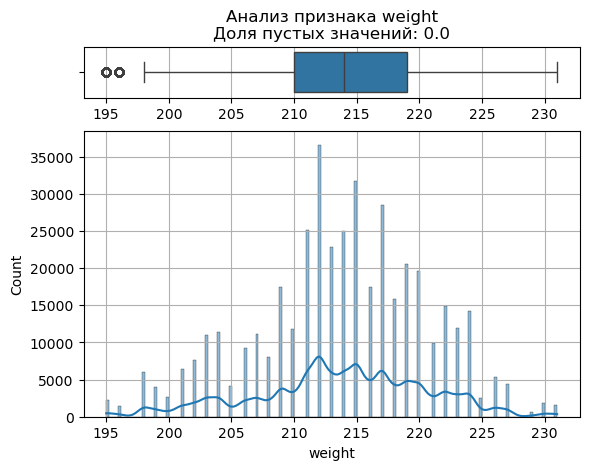

In [ ]:
plot_stat_priznak('weight')

Норма. Немного незначительных выбросов

##### driverid

count    425920.000000
mean       2890.877688
std          11.513194
min        2875.000000
25%        2878.000000
50%        2889.000000
75%        2902.000000
max        2909.000000
Name: driverid, dtype: float64


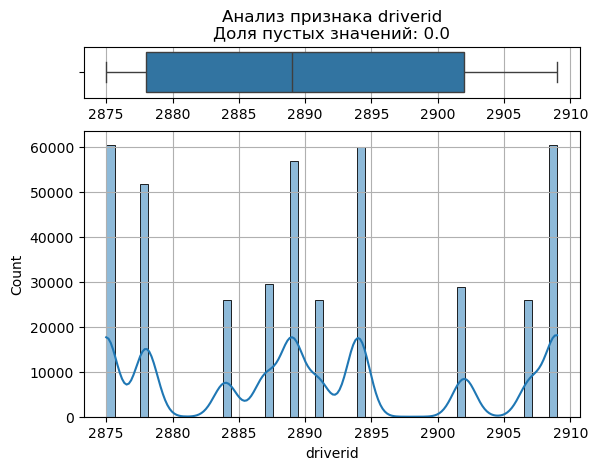

In [ ]:
plot_stat_priznak('driverid')

Норма

##### w_fl

count    425920.000000
mean          0.455475
std           0.498014
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: w_fl, dtype: float64


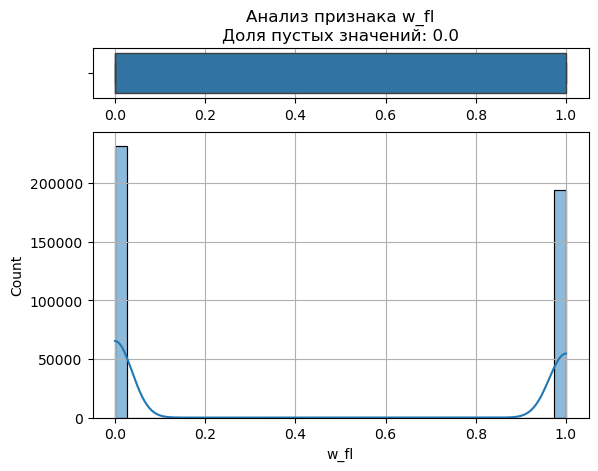

In [ ]:
plot_stat_priznak('w_fl')

Норма

In [ ]:
data.isnull().sum()

objectid                0
time                    0
lat                     0
lon                     0
speed                   0
height                  0
fuel_cons               0
engine_speed            0
hdop                    0
DQ_vertical_bump        0
accelerator_position    0
fuel_tank_level         0
weight_dynamic          0
tripid                  0
weight                  0
driverid                0
w_fl                    0
x                       0
y                       0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425920 entries, 0 to 425919
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   objectid              425920 non-null  int64  
 1   time                  425920 non-null  object 
 2   lat                   425920 non-null  float64
 3   lon                   425920 non-null  float64
 4   speed                 425920 non-null  float64
 5   height                425920 non-null  float64
 6   fuel_cons             425920 non-null  float64
 7   engine_speed          425920 non-null  float64
 8   hdop                  425920 non-null  float64
 9   DQ_vertical_bump      425920 non-null  int64  
 10  accelerator_position  425920 non-null  int64  
 11  fuel_tank_level       425920 non-null  float64
 12  weight_dynamic        425920 non-null  float64
 13  tripid                425920 non-null  float64
 14  weight                425920 non-null  float64
 15  

In [ ]:
data['time'] = pd.to_datetime(data['time'], format = 'ISO8601')
data['tripid'] = data['tripid'].astype(dtype = 'int32')
data['driverid'] = data['driverid'].astype(dtype = 'int16')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425920 entries, 0 to 425919
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype                    
---  ------                --------------   -----                    
 0   objectid              425920 non-null  int64                    
 1   time                  425920 non-null  datetime64[ns, UTC+07:00]
 2   lat                   425920 non-null  float64                  
 3   lon                   425920 non-null  float64                  
 4   speed                 425920 non-null  float64                  
 5   height                425920 non-null  float64                  
 6   fuel_cons             425920 non-null  float64                  
 7   engine_speed          425920 non-null  float64                  
 8   hdop                  425920 non-null  float64                  
 9   DQ_vertical_bump      425920 non-null  int64                    
 10  accelerator_position  425920 non-null  int64

##### Небольшие изменения в типах данных

In [ ]:
data['time'] = pd.to_datetime(data['time'], format = 'ISO8601')
data['tripid'] = data['tripid'].astype(dtype = 'int32')
data['driverid'] = data['driverid'].astype(dtype = 'int16')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425920 entries, 0 to 425919
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype                    
---  ------                --------------   -----                    
 0   objectid              425920 non-null  int64                    
 1   time                  425920 non-null  datetime64[ns, UTC+07:00]
 2   lat                   425920 non-null  float64                  
 3   lon                   425920 non-null  float64                  
 4   speed                 425920 non-null  float64                  
 5   height                425920 non-null  float64                  
 6   fuel_cons             425920 non-null  float64                  
 7   engine_speed          425920 non-null  float64                  
 8   hdop                  425920 non-null  float64                  
 9   DQ_vertical_bump      425920 non-null  int64                    
 10  accelerator_position  425920 non-null  int64

##### Дубликаты

In [ ]:
data.duplicated().sum()

112

In [ ]:
data = data.drop_duplicates()
data.duplicated().sum()

0

##### Небольшие изменения в типах данных

In [ ]:
data['tripid'] = data['tripid'].astype(dtype = 'int32')
data['driverid'] = data['driverid'].astype(dtype = 'int16')

<a id = 'задание1_6'></a>

##### Предположить, что обозначают значения колонки w_fl (путем анализа имеющихся данных) - ответ написать в текстовом поле и обосновать

[к оглавлению](#title) 

In [ ]:
data[priznak_list].corr()['w_fl']

speed                   0.016977
height                 -0.005643
fuel_cons               0.311194
engine_speed            0.107231
hdop                    0.022145
DQ_vertical_bump             NaN
accelerator_position         NaN
fuel_tank_level        -0.046775
weight_dynamic          0.586070
tripid                 -0.041349
weight                 -0.053760
driverid               -0.020610
w_fl                    1.000000
Name: w_fl, dtype: float64

<Axes: title={'center': 'Карта после выяснения предназначения датчика w_fl\n'}, xlabel='lon', ylabel='lat'>

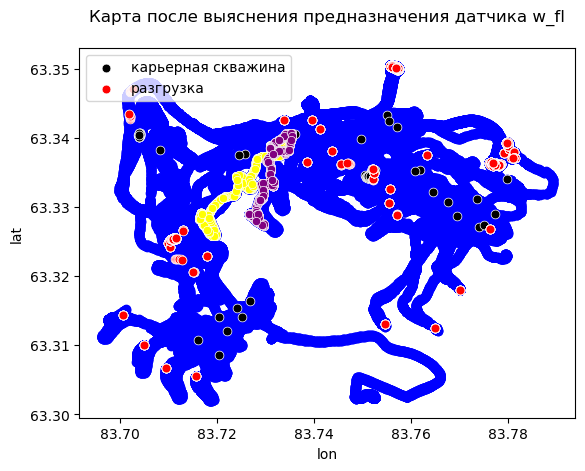

In [ ]:
map_plotting()
sns.scatterplot(data = data[(data['tripid'] == data['tripid'].unique()[0]) & (data['w_fl'] == 0)],
                x = 'lon',
                y = 'lat',
                color = 'yellow')
sns.scatterplot(data = data[(data['tripid'] == data['tripid'].unique()[0]) & (data['w_fl'] == 1)],
                x = 'lon',
                y = 'lat',
                color = 'purple')

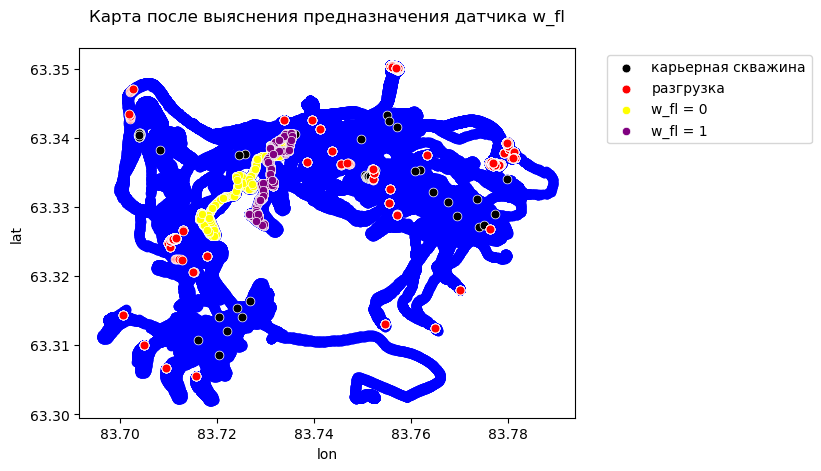

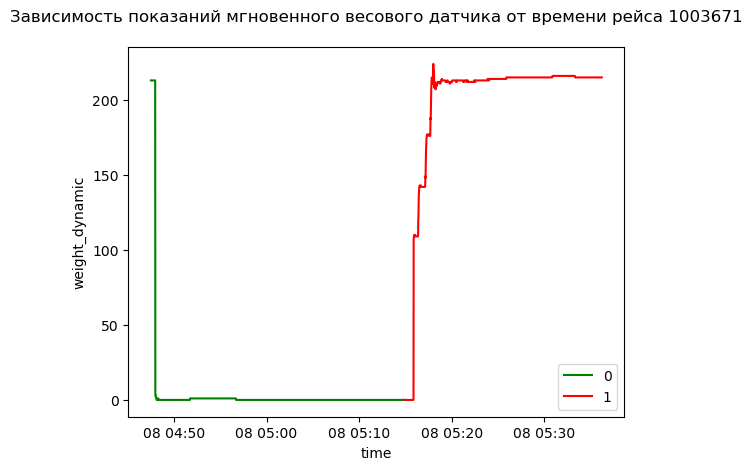

In [ ]:
trip = data['tripid'].unique()[0]
w_fl_detector = data[data['tripid'] == trip]


map_plotting()
sns.scatterplot(data = data[(data['tripid'] == trip) & (data['w_fl'] == 0)],
                x = 'lon',
                y = 'lat',
                color = 'yellow',
                label = 'w_fl = 0')
sns.scatterplot(data = data[(data['tripid'] == trip) & (data['w_fl'] == 1)],
                x = 'lon',
                y = 'lat',
                color = 'purple',
                label = 'w_fl = 1')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()


sns.lineplot(data = w_fl_detector[w_fl_detector['w_fl'] == 0],
             x = 'time',
             y = 'weight_dynamic',
             color = 'green',
             label = '0')
sns.lineplot(data = w_fl_detector[w_fl_detector['w_fl'] == 1],
             x = 'time',
             y = 'weight_dynamic',
             color = 'red',
             label = '1')
plt.title('Зависимость показаний мгновенного весового датчика от времени рейса {}\n'.format(trip))
plt.show()

In [ ]:
w_fl_detector.head()

objectid                             time        lat        lon  \
0        1121 2023-11-08 05:31:31.309000+07:00  63.328824  83.727988   
30       1121 2023-11-08 04:49:08.317000+07:00  63.328224  83.716488   
103      1121 2023-11-08 05:07:27.371000+07:00  63.338924  83.731588   
134      1121 2023-11-08 05:15:50.368000+07:00  63.338524  83.730988   
160      1121 2023-11-08 05:17:12.349000+07:00  63.338524  83.730988   

        speed  height  fuel_cons  engine_speed   hdop  DQ_vertical_bump  \
0    3.003940   195.7      390.0   1099.331509  99.99                 0   
30   3.033580   219.2       81.0   1099.331509  99.99                 0   
103  0.000000   152.9       27.0   1099.331509  99.99                 0   
134  0.396328   154.7       27.0   1099.331509  99.99                 0   
160  0.488928   154.4       31.0   1099.331509  99.99                 0   

     accelerator_position  fuel_tank_level  weight_dynamic   tripid  weight  \
0                       0             60.0           216.0  1003671   215.0   
30                      0             63.0             0.0  1003671   215.0   
103                     0             62.0             0.0  1003671   215.0   
134                     0             64.0             0.0  1003671   215.0   
160                     0             64.0           161.0  1003671   215.0   

     driverid  w_fl              x             y  
0        2891     1  636592.202274  7.025133e+06  
30       2891     0  636019.480326  7.025042e+06  
103      2891     0  636724.425933  7.026265e+06  
134      2891     1  636696.306315  7.026220e+06  
160      2891     1  636696.306315  7.026220e+06

w_fl - это датчик бинарного весового контроля
 - 0 - разгрузка / следование в зону погрузки (т.е. когда самосвал разгружается или пустой)
 - 1 - погрузка / сдедование в зону разгрузки (т.е. когда самосвал загружается или загруженный)

---
---

## Задание 2

Все пункты делаются на данных, оставшихся после чистки в Задании 1. Правильных ответов (по числам) нет, т к препроцессинг может отличаться. Нам интересно увидеть, как Вы это делаете.
* Вывести средние значения параметров ['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height'] по самосвалам
* Построить гистограмму суммарных расстояний за каждый рейс.
* Вывести таблицу средних скоростей самосвалов за каждый час суток (формат: колонки - час суток, строки - самосвалы, в ячейках - средняя скорость)
* Выбрать по одному рейсу для каждого самосвала. Для каждого рейса: нарисовать его на общей карте карьера, нарисовать на одном графике кривую изменения скорости от времени и высоты от времени (шкалы должны быть на разных осях).
* Присоединить данные погоды к данным телеметрии

<a id = 'задание2_1'></a>

##### Вывести средние значения параметров ['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height'] по самосвалам

[к оглавлению](#title) 

In [ ]:
data.groupby('objectid')[['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height']].mean().round(2)

hdop  speed  engine_speed  DQ_vertical_bump  height
objectid                                                      
1121      92.96   9.91       1099.33               0.0   62.04
1123       2.47  16.34       1099.33               0.0   90.76
1124       7.04  12.79       1135.72               0.0  266.99
1125       8.44  13.72       1000.70               0.0  264.88
1126       7.58  13.43       1161.57               0.0  262.75

<a id = 'задание2_2'></a>

##### Построить гистограмму суммарных расстояний за каждый рейс.

[к оглавлению](#title) 

In [ ]:
way_df = data[['tripid', 'time', 'x', 'y']]
way_df.head()

tripid                             time              x             y
0  1003671 2023-11-08 05:31:31.309000+07:00  636592.202274  7.025133e+06
1  1003657        2023-11-08 03:21:39+07:00  637716.857273  7.025866e+06
2  1003798        2023-11-08 19:20:55+07:00  637106.943106  7.026803e+06
3  1003749        2023-11-08 14:16:39+07:00  637713.403209  7.026795e+06
4  1003728 2023-11-08 11:09:49.347000+07:00  638449.084136  7.025559e+06

In [ ]:
way_df_1 = way_df[way_df['tripid'] == 1003626][['tripid', 'time', 'x', 'y']].sort_values(by = 'time')
way_df_1['x_shift'], way_df_1['y_shift'] = way_df_1['x'].shift(-1), way_df_1['y'].shift(-1)

def pifagor(row):
    return np.sqrt((row['x_shift'] - row['x'])**2 + (row['y_shift'] - row['y'])**2)

way_df_1['way'] = way_df_1.apply(pifagor, axis = 1)
way_df_1['way'].sum()

4992.444573634153

In [ ]:
way_result = []
for tripid in data['tripid'].unique():
    way_df_1 = data[data['tripid'] == tripid][['time', 'x', 'y']].sort_values(by = 'time')
    way_df_1['x_shift'], way_df_1['y_shift'] = way_df_1['x'].shift(-1), way_df_1['y'].shift(-1)
    way_df_1['way'] = way_df_1.apply(pifagor, axis = 1)
    sum_way = way_df_1['way'].sum()
    way_result.append(sum_way.round())

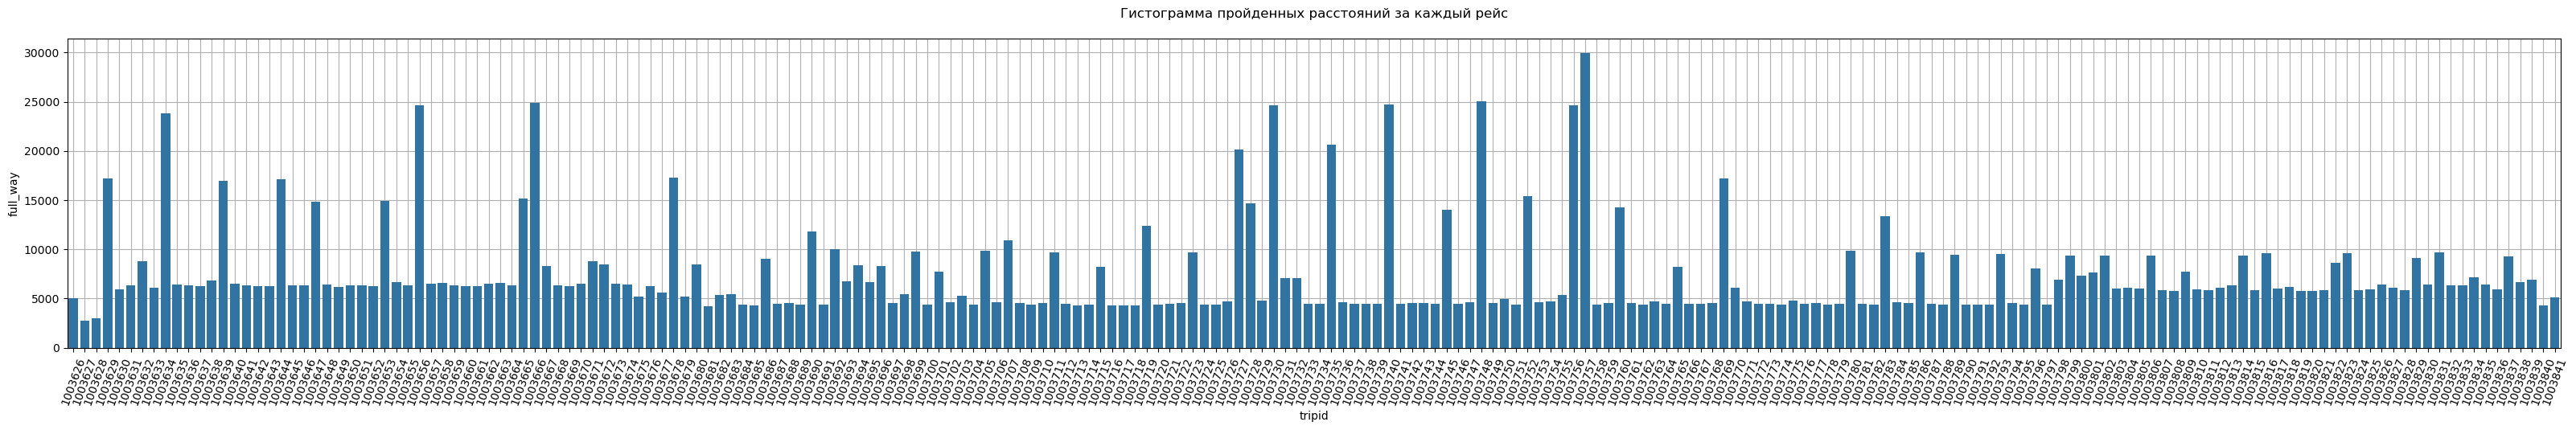

In [ ]:
way_df = pd.DataFrame(zip(data['tripid'].unique(), way_result), columns = ['tripid', 'full_way'])
way_df['tripid'] = way_df['tripid'].astype('object')
way_df['tripid'] = way_df['tripid'].astype('object')

way_df.to_csv('way_df.csv', index = False) # Понадобиться для будущего кодирования признака tripid

plt.figure(figsize = (40,5))
ax=\
sns.barplot(data = way_df.sort_values(by = 'tripid'),
            y = 'full_way',
            x = 'tripid')
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
ax.set_axisbelow(True)
plt.title('Гистограмма пройденных расстояний за каждый рейс\n')
plt.grid()

<a id = 'задание2_3'></a>

##### Вывести таблицу средних скоростей самосвалов за каждый час суток (формат: колонки - час суток, строки - самосвалы, в ячейках - средняя скорость)

[к оглавлению](#title) 

In [ ]:
data['day'] = data['time'].dt.date
data['hour'] = data['time'].dt.hour

data.pivot_table(values = 'speed',
                 index = ['objectid', 'day', 'hour'],
                 aggfunc = 'mean'
                 )

speed
objectid day        hour           
1121     2023-11-08 0     18.389827
                    1     12.899335
                    2      8.235196
                    3      6.410654
                    4     13.865112
...                             ...
1126     2023-11-08 20    17.955361
                    21    20.612500
                    22    15.397639
                    23    15.169694
         2023-11-09 0     37.900000

[123 rows x 1 columns]

<a id = 'задание2_4'></a>

##### Выбрать по одному рейсу для каждого самосвала. Для каждого рейса: нарисовать его на общей карте карьера, нарисовать на одном графике кривую изменения скорости от времени и высоты от времени (шкалы должны быть на разных осях).

[к оглавлению](#title) 

________________________
Самосвал: 1121
Рейс: 1003671


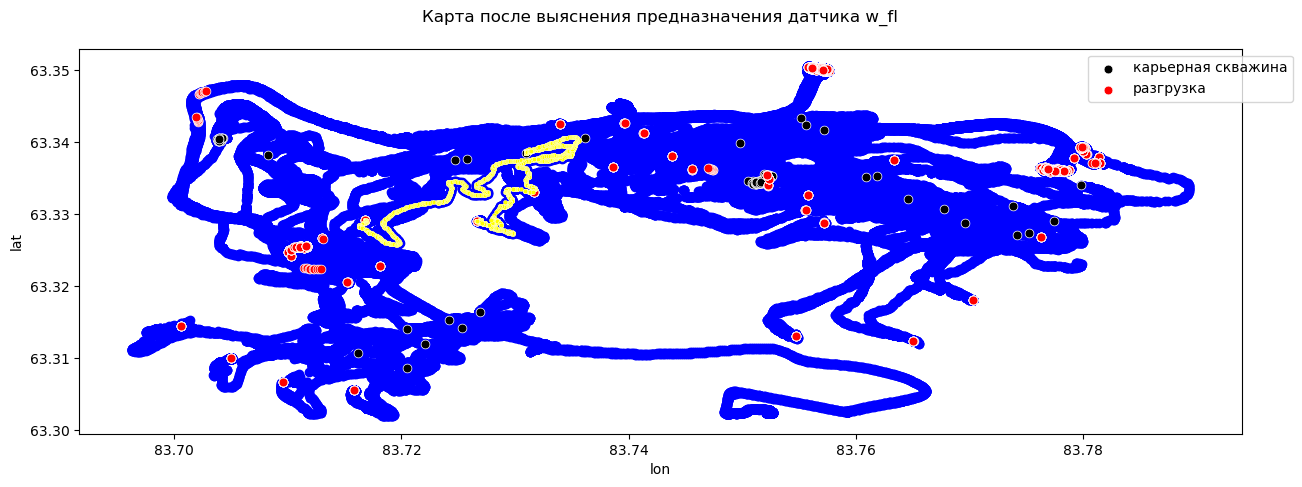

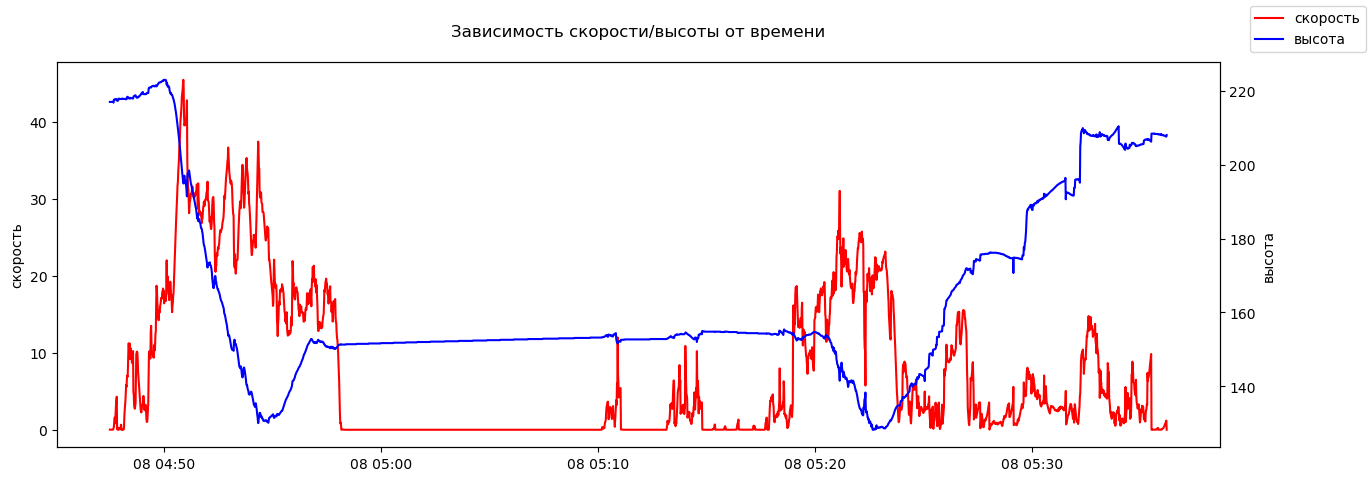

________________________
Самосвал: 1125
Рейс: 1003657


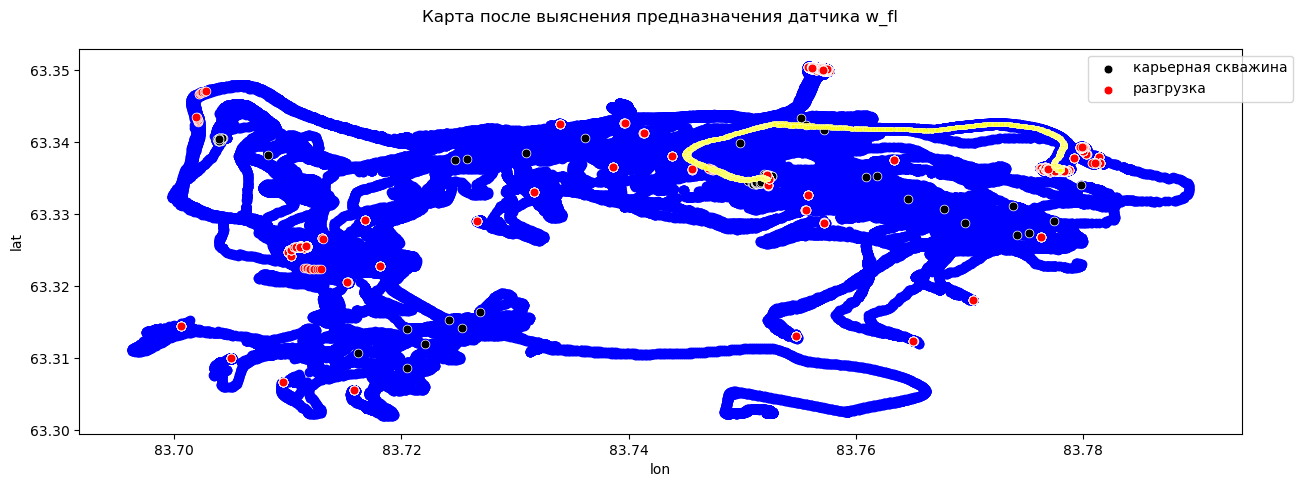

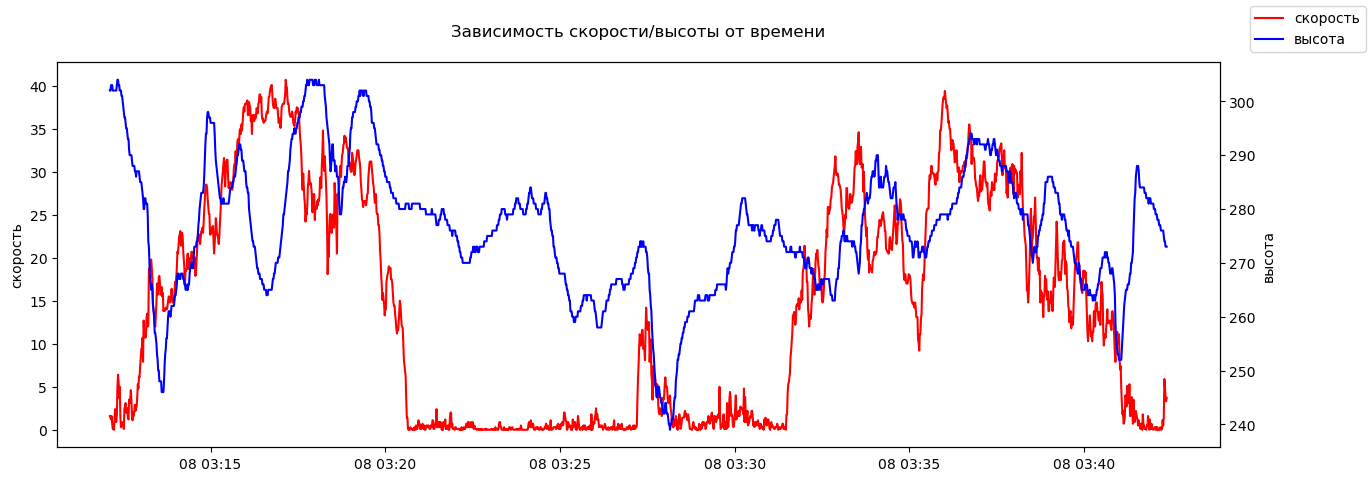

________________________
Самосвал: 1124
Рейс: 1003798


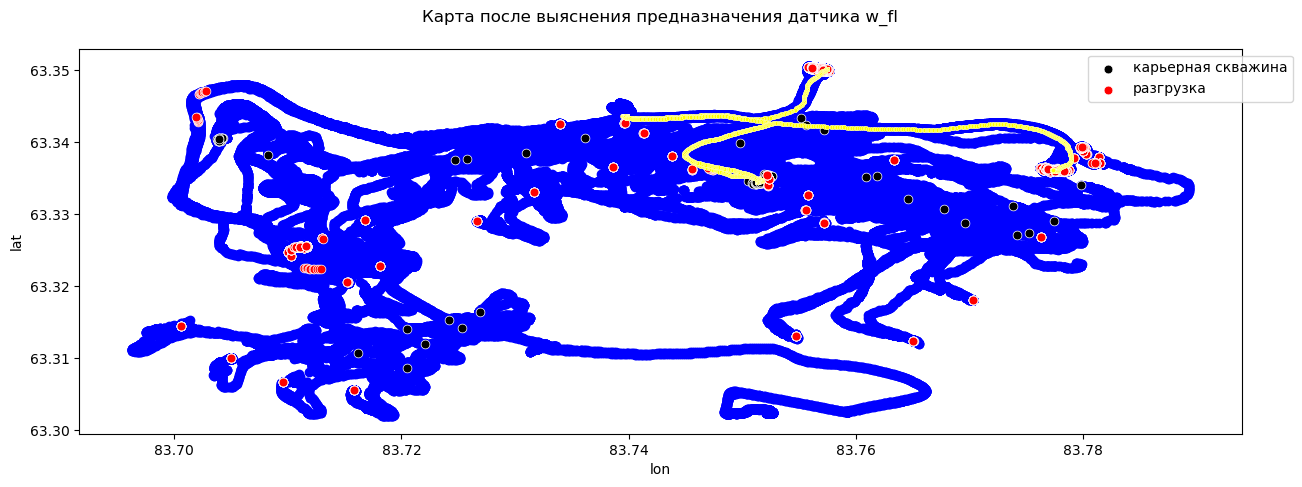

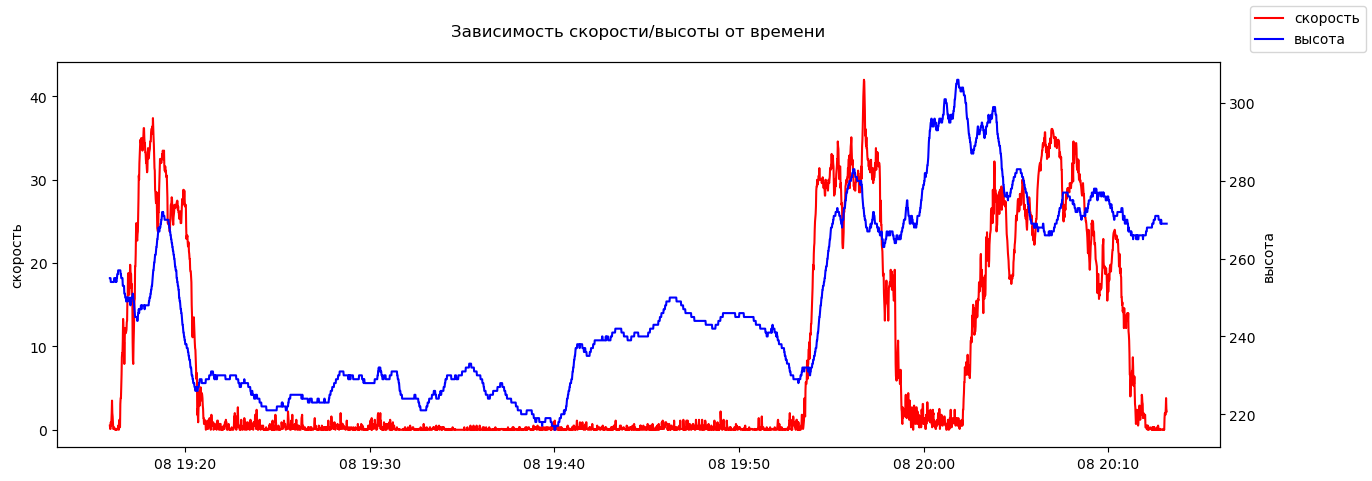

________________________
Самосвал: 1126
Рейс: 1003662


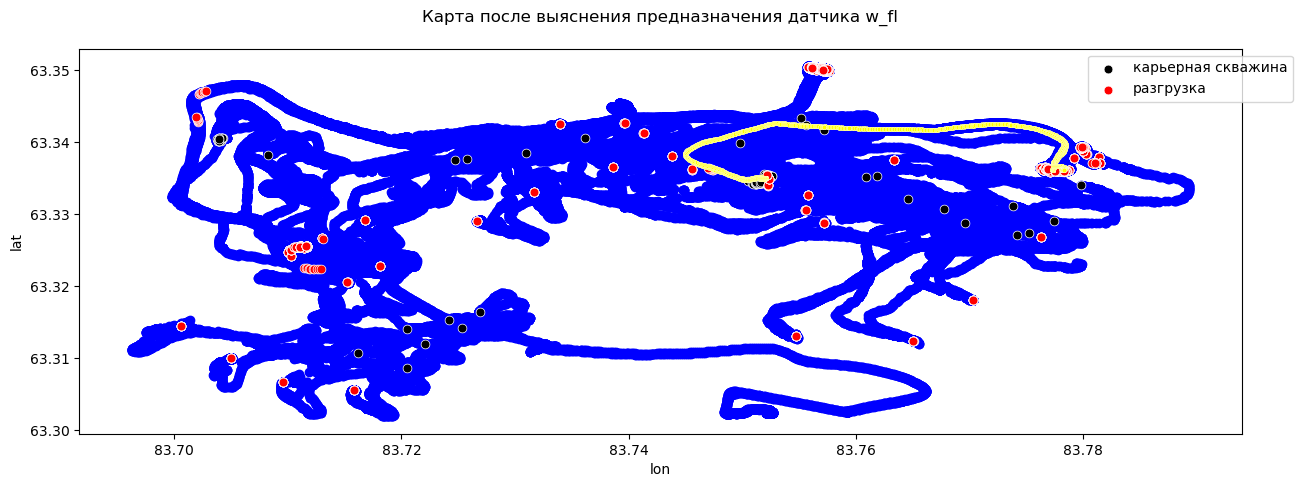

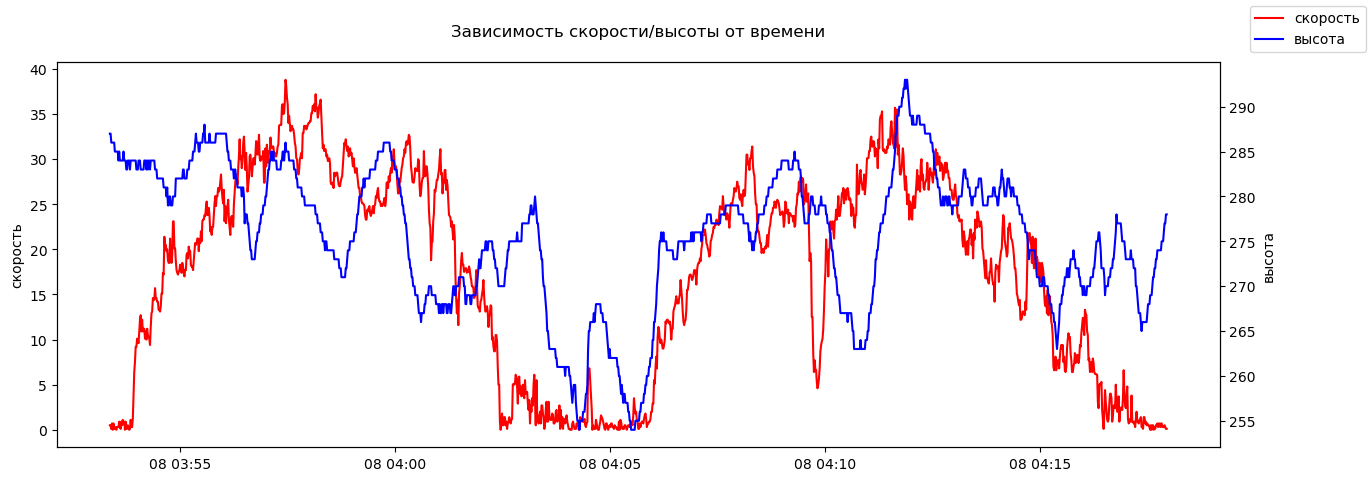

________________________
Самосвал: 1123
Рейс: 1003705


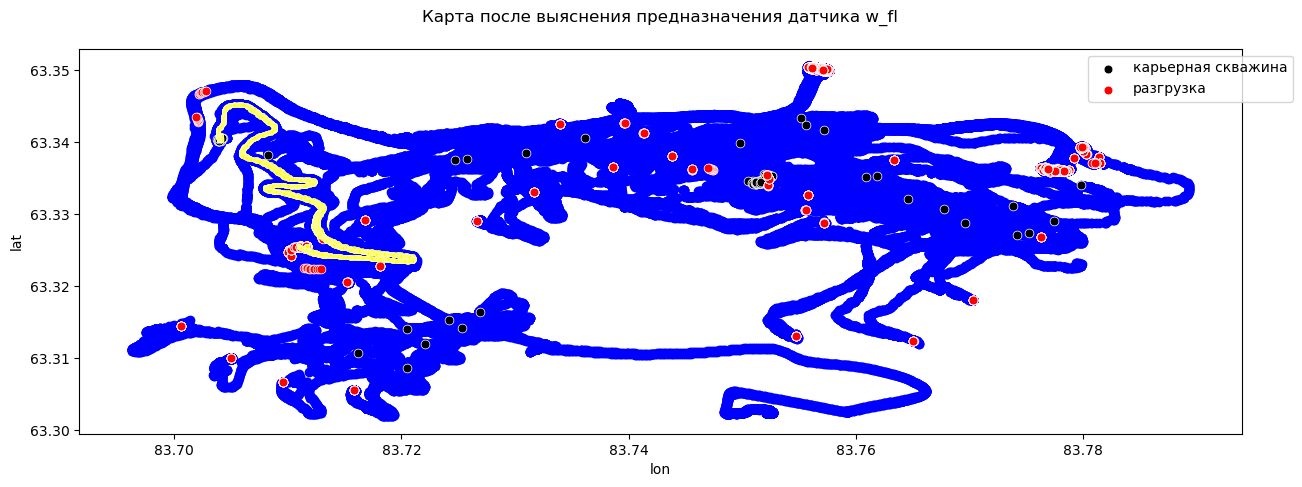

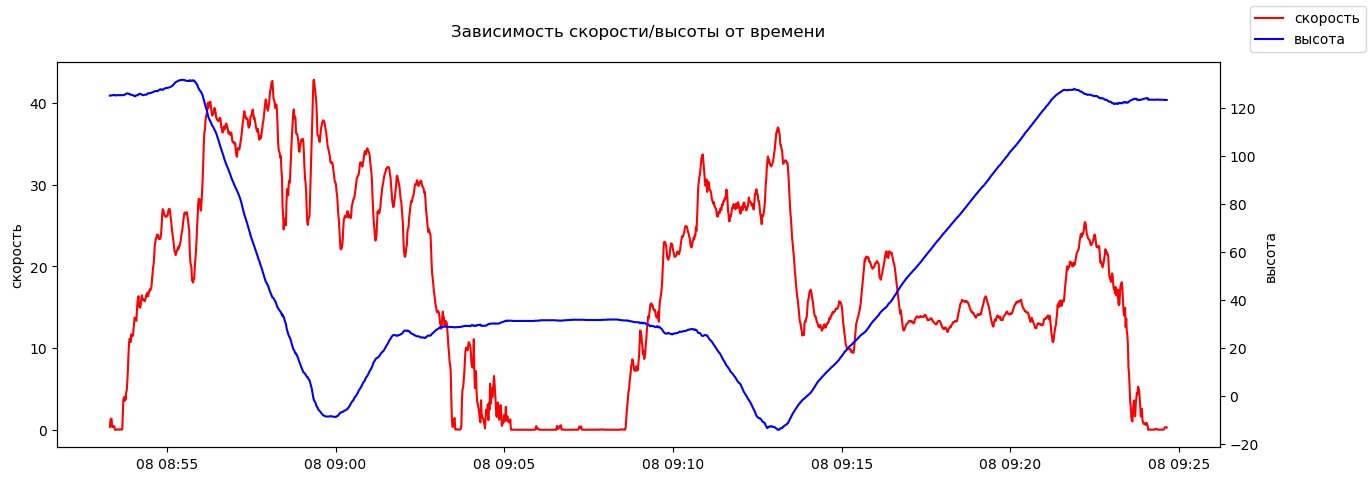

In [ ]:
def plot_zadanie(df):
    plt.figure(figsize =(15,5))
    map_plotting()
    sns.scatterplot(data = df,
                    x = 'lon',
                    y = 'lat',
                    color = 'yellow',
                    s = 10)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

    fig, ax = plt.subplots(figsize = (15,5))
    ax1 = ax.twinx()
    ax.plot(df['time'], df['speed'],color='red')
    ax1.plot(df['time'],df['height'],color='blue')
    ax.set_ylabel('скорость')
    ax1.set_ylabel('высота')
    # ax.legend(loc = 'upper center')
    # ax1.legend(loc = 'center')
    # plt.figlegend([ax, ax1], ['adad', 'dawd'])
    fig.legend([ax, ax1], labels = ['скорость', 'высота'], loc = 'upper right')
    plt.title('Зависимость скорости/высоты от времени\n')
    plt.show()



for objectid in data['objectid'].unique():
    tripid = data[data['objectid'] == objectid]['tripid'].iloc[0]
    df = data[(data['objectid'] == objectid) & (data['tripid'] == tripid)].sort_values(by = 'time')

    print('________________________')
    print('Самосвал: {}\nРейс: {}'.format(objectid, tripid))
    plot_zadanie(df)

<a id = 'задание2_5'></a>

##### Присоединить данные погоды к данным телеметрии

[к оглавлению](#title) 

In [ ]:
weather['day'] = weather['time'].dt.date
weather['hour'] = weather['time'].dt.hour

data = data.merge(weather.drop('time',axis = 1), on = ['day', 'hour'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425808 entries, 0 to 425807
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype                    
---  ------                --------------   -----                    
 0   objectid              425808 non-null  int64                    
 1   time                  425808 non-null  datetime64[ns, UTC+07:00]
 2   lat                   425808 non-null  float64                  
 3   lon                   425808 non-null  float64                  
 4   speed                 425808 non-null  float64                  
 5   height                425808 non-null  float64                  
 6   fuel_cons             425808 non-null  float64                  
 7   engine_speed          425808 non-null  float64                  
 8   hdop                  425808 non-null  float64                  
 9   DQ_vertical_bump      425808 non-null  int64                    
 10  accelerator_position  425808 non-null  int64

In [ ]:
data = data.drop(['day', 'hour'], axis = 1)
data.to_csv('frame.csv', index = False)

## Задание 3

**Обучить модель для предсказания значений скорости самосвала (колонка speed)**
* Можно (и даже нужно) генерировать дополнительные фичи.
* Выполнить необходимые (на Ваш взгляд) преобразования датасета.
* Выбрать метрику(и) для оценки качества модели, объяснить причину выбора данной метрики
* Обучить несколько моделей и сравнить их. Интерпретировать результаты.

In [2]:
df = pd.read_csv('frame.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425808 entries, 0 to 425807
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   objectid              425808 non-null  int64  
 1   time                  425808 non-null  object 
 2   lat                   425808 non-null  float64
 3   lon                   425808 non-null  float64
 4   speed                 425808 non-null  float64
 5   height                425808 non-null  float64
 6   fuel_cons             425808 non-null  float64
 7   engine_speed          425808 non-null  float64
 8   hdop                  425808 non-null  float64
 9   DQ_vertical_bump      425808 non-null  int64  
 10  accelerator_position  425808 non-null  int64  
 11  fuel_tank_level       425808 non-null  float64
 12  weight_dynamic        425808 non-null  float64
 13  tripid                425808 non-null  int64  
 14  weight                425808 non-null  float64
 15  

<a id = 'задание3_2'></a>

##### Выполнить необходимые (на Ваш взгляд) преобразования датасета.

[к оглавлению](#title) 

Для генерации модели предсказания скорости важно понимать: 

- цель предсказания (для чего это нужно предсказывать)
- нужно ли оставлять все признаки (т.е. предполагаем ли мы что данные погоды могут добаляться (например будут ли измекнения в признаке precipType, no_weather_info))
- нужны ли нам данные о tripid / driverid / objectid или опираться только на погоду-датчики (на это можно ответить узнав для какой цели мы предсказываем скорость)

In [3]:
df.columns

Index(['objectid', 'time', 'lat', 'lon', 'speed', 'height', 'fuel_cons',
       'engine_speed', 'hdop', 'DQ_vertical_bump', 'accelerator_position',
       'fuel_tank_level', 'weight_dynamic', 'tripid', 'weight', 'driverid',
       'w_fl', 'x', 'y', 'precipIntensity', 'precipProbability', 'temperature',
       'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed',
       'windGust', 'windBearing', 'cloudCover', 'visibility', 'precipType',
       'rain', 'snow', 'no_weather_info'],
      dtype='object')

In [4]:
print('Количество уникальных значений признаков показаний датчиков:')
print('________________________________________________')
for i in ['objectid',
          'speed',
          'height',
          'fuel_cons',
          'engine_speed',
          'hdop',
          'DQ_vertical_bump',
          'accelerator_position',
          'fuel_tank_level',
          'weight_dynamic',
          'tripid',
          'weight',
          'driverid',
          'w_fl']:
    print('{}: -----> {}'.format(i, len(df[i].unique())))

Количество уникальных значений признаков показаний датчиков:
________________________________________________
objectid: -----> 5
speed: -----> 22091
height: -----> 6373
fuel_cons: -----> 8516
engine_speed: -----> 8121
hdop: -----> 886
DQ_vertical_bump: -----> 1
accelerator_position: -----> 1
fuel_tank_level: -----> 90
weight_dynamic: -----> 196
tripid: -----> 216
weight: -----> 35
driverid: -----> 10
w_fl: -----> 2


In [5]:
print('Количество уникальных значений признаков погоды:')
print('________________________________________________')
for i in ['precipIntensity',
          'precipProbability',
          'temperature',
          'apparentTemperature',
          'dewPoint',
          'humidity',
          'pressure',
          'windSpeed',
          'windGust',
          'windBearing',
          'cloudCover',
          'visibility',
          'precipType',
          'rain',
          'snow',
          'no_weather_info']:
    print('{}: -----> {}'.format(i, len(df[i].unique())))

Количество уникальных значений признаков погоды:
________________________________________________
precipIntensity: -----> 4
precipProbability: -----> 7
temperature: -----> 10
apparentTemperature: -----> 22
dewPoint: -----> 22
humidity: -----> 19
pressure: -----> 10
windSpeed: -----> 23
windGust: -----> 24
windBearing: -----> 20
cloudCover: -----> 1
visibility: -----> 7
precipType: -----> 2
rain: -----> 1
snow: -----> 2
no_weather_info: -----> 1


- Будем обучать модель без выброса признаков погоды с одним уникальным значение. Т.е. предполагаем, что например rain в будущем может быть 1 и т.д.
- Отбросим  признаки:
    - DQ_vertical_bump, accelerator_position (т.к. датчики видимо нерабочие на всех самосвалах и не понятно будут ли их ремонтировать) (а может их отсутствие это просто ошибка фрейма -- есть задание с выводом среднего по признаку DQ_vertical_bump)
    - time (как связующее звено между погодой и показаниями датчиков). Но оставим признак часа (т.к. это можно считать признаком видимости (заход солнца))
    - snow - т.к. признак дублирует precipType
    - tripid - т.к. 
    - также необходимо посмотреть на корреляцию lon, lat, x , y (информация повторяется - необхожимости в обоих нет) 

Но прежде проверим сколько рейсов зафиксированно 2023-11-09

In [6]:
df['time'] = pd.to_datetime(df['time'], format = 'ISO8601')
df['hour'] = df['time'].dt.hour
df['day'] = df['time'].dt.date.map(lambda x: str(x))

In [7]:
two_days = df.groupby('tripid')['day'].nunique().reset_index()
for id in two_days[two_days['day'] != 1]['tripid']:
    print('В рейсе {} было зафиксировано {} строк показаний датчиков 9 ноября'.format(id, 
                                                                                      len(df[(df['tripid'] == id) & (df['day'] == '2023-11-09')])))

В рейсе 1003837 было зафиксировано 1 строк показаний датчиков 9 ноября
В рейсе 1003838 было зафиксировано 1 строк показаний датчиков 9 ноября
В рейсе 1003840 было зафиксировано 1 строк показаний датчиков 9 ноября


In [8]:
df[df['day'] == '2023-11-09']

objectid                      time        lat        lon  speed  \
425805      1125 2023-11-09 00:00:00+07:00  63.334840  83.751774    0.0   
425806      1124 2023-11-09 00:00:00+07:00  63.338789  83.778529   23.7   
425807      1126 2023-11-09 00:00:00+07:00  63.342207  83.756331   37.9   

        height  fuel_cons  engine_speed  hdop  DQ_vertical_bump  ...  \
425805   266.0       2.50       749.750   7.0                 0  ...   
425806   281.0     100.45      1320.875   6.0                 0  ...   
425807   273.0      16.25       701.000   6.0                 0  ...   

        windGust  windBearing  cloudCover  visibility  precipType  rain  snow  \
425805      8.81        164.0       100.0       222.0        snow     0     1   
425806      8.81        164.0       100.0       222.0        snow     0     1   
425807      8.81        164.0       100.0       222.0        snow     0     1   

        no_weather_info  hour         day  
425805                1     0  2023-11-09  
425806                1     0  2023-11-09  
425807                1     0  2023-11-09  

[3 rows x 37 columns]

Видим что если рейс если и был зафиксирован датчиками не толко 8 ноября, но и 9 -- то только одной строкой (конец рейса в 00:00:00 9 ноября ) ---> не будем удалять эти 3 строки, т.к. в признак времени мы удалим (кроме признака 'час дня')

Предположим, что рейс это константа изо дня в день

In [9]:
df = df.drop(['DQ_vertical_bump', 'accelerator_position', 'time', 'snow', 'no_weather_info', 'day'], axis = 1)

Для просмотра корреляционной матрицы надо: 
 - убрать object типы: precipType --> OneHot
 - objectid ---> OneHot
 - driverid --> OneHot
 - tripid ---> кодировать пройденным расстоянием

In [10]:
df = pd.concat([df,
                pd.get_dummies(df['precipType'], dtype = float, columns = ['clouds_', 'snow_'])],
                axis = 1).drop('precipType', axis = 1)
df = pd.concat([df,
                pd.get_dummies(df['objectid'], dtype = float)],
                axis = 1).drop('objectid', axis = 1)
df = pd.concat([df,
                pd.get_dummies(df['driverid'], dtype = float)],
                axis = 1).drop('driverid', axis = 1)
df.head()


lat        lon     speed  height  fuel_cons  engine_speed   hdop  \
0  63.328824  83.727988   3.00394   195.7      390.0   1099.331509  99.99   
1  63.336234  83.748103  19.80000   260.0      206.9   1465.000000   8.00   
2  63.343324  83.744388  15.89020   245.3      399.0   1099.331509   1.25   
3  63.342410  83.754578  26.20000   276.0      179.5   1323.750000   6.00   
4  63.335362  83.752028   0.50000   294.0       46.1    825.000000   6.00   

   fuel_tank_level  weight_dynamic   tripid  ...  2875  2878  2884  2887  \
0        60.000000       216.00000  1003671  ...   0.0   0.0   0.0   0.0   
1        47.990865        96.30526  1003674  ...   0.0   0.0   0.0   1.0   
2        31.000000       214.00000  1003666  ...   0.0   0.0   0.0   0.0   
3        47.990865        96.30526  1003675  ...   0.0   0.0   1.0   0.0   
4        47.990865        96.30526  1003672  ...   0.0   0.0   1.0   0.0   

   2889  2891  2894  2902  2907  2909  
0   0.0   1.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   1.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 45 columns]

tripid ---> кодировать пройденным расстоянием

In [11]:
way_df = pd.read_csv('way_df.csv')
way_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tripid    216 non-null    int64  
 1   full_way  216 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


In [12]:
df = df.merge(way_df, on = 'tripid', how = 'left').drop('tripid', axis = 1).rename({'full_way': 'tripid_mask'}, axis = 1)
df.head()

lat        lon     speed  height  fuel_cons  engine_speed   hdop  \
0  63.328824  83.727988   3.00394   195.7      390.0   1099.331509  99.99   
1  63.336234  83.748103  19.80000   260.0      206.9   1465.000000   8.00   
2  63.343324  83.744388  15.89020   245.3      399.0   1099.331509   1.25   
3  63.342410  83.754578  26.20000   276.0      179.5   1323.750000   6.00   
4  63.335362  83.752028   0.50000   294.0       46.1    825.000000   6.00   

   fuel_tank_level  weight_dynamic  weight  ...  2878  2884  2887  2889  2891  \
0        60.000000       216.00000   215.0  ...   0.0   0.0   0.0   0.0   1.0   
1        47.990865        96.30526   211.0  ...   0.0   0.0   1.0   0.0   0.0   
2        31.000000       214.00000   214.0  ...   0.0   0.0   0.0   0.0   0.0   
3        47.990865        96.30526   215.0  ...   0.0   1.0   0.0   0.0   0.0   
4        47.990865        96.30526   220.0  ...   0.0   1.0   0.0   0.0   0.0   

   2894  2902  2907  2909  tripid_mask  
0   0.0   0.0   0.0   0.0       8795.0  
1   0.0   0.0   0.0   0.0       6456.0  
2   0.0   1.0   0.0   0.0      24863.0  
3   0.0   0.0   0.0   0.0       5210.0  
4   0.0   0.0   0.0   0.0       8500.0  

[5 rows x 45 columns]

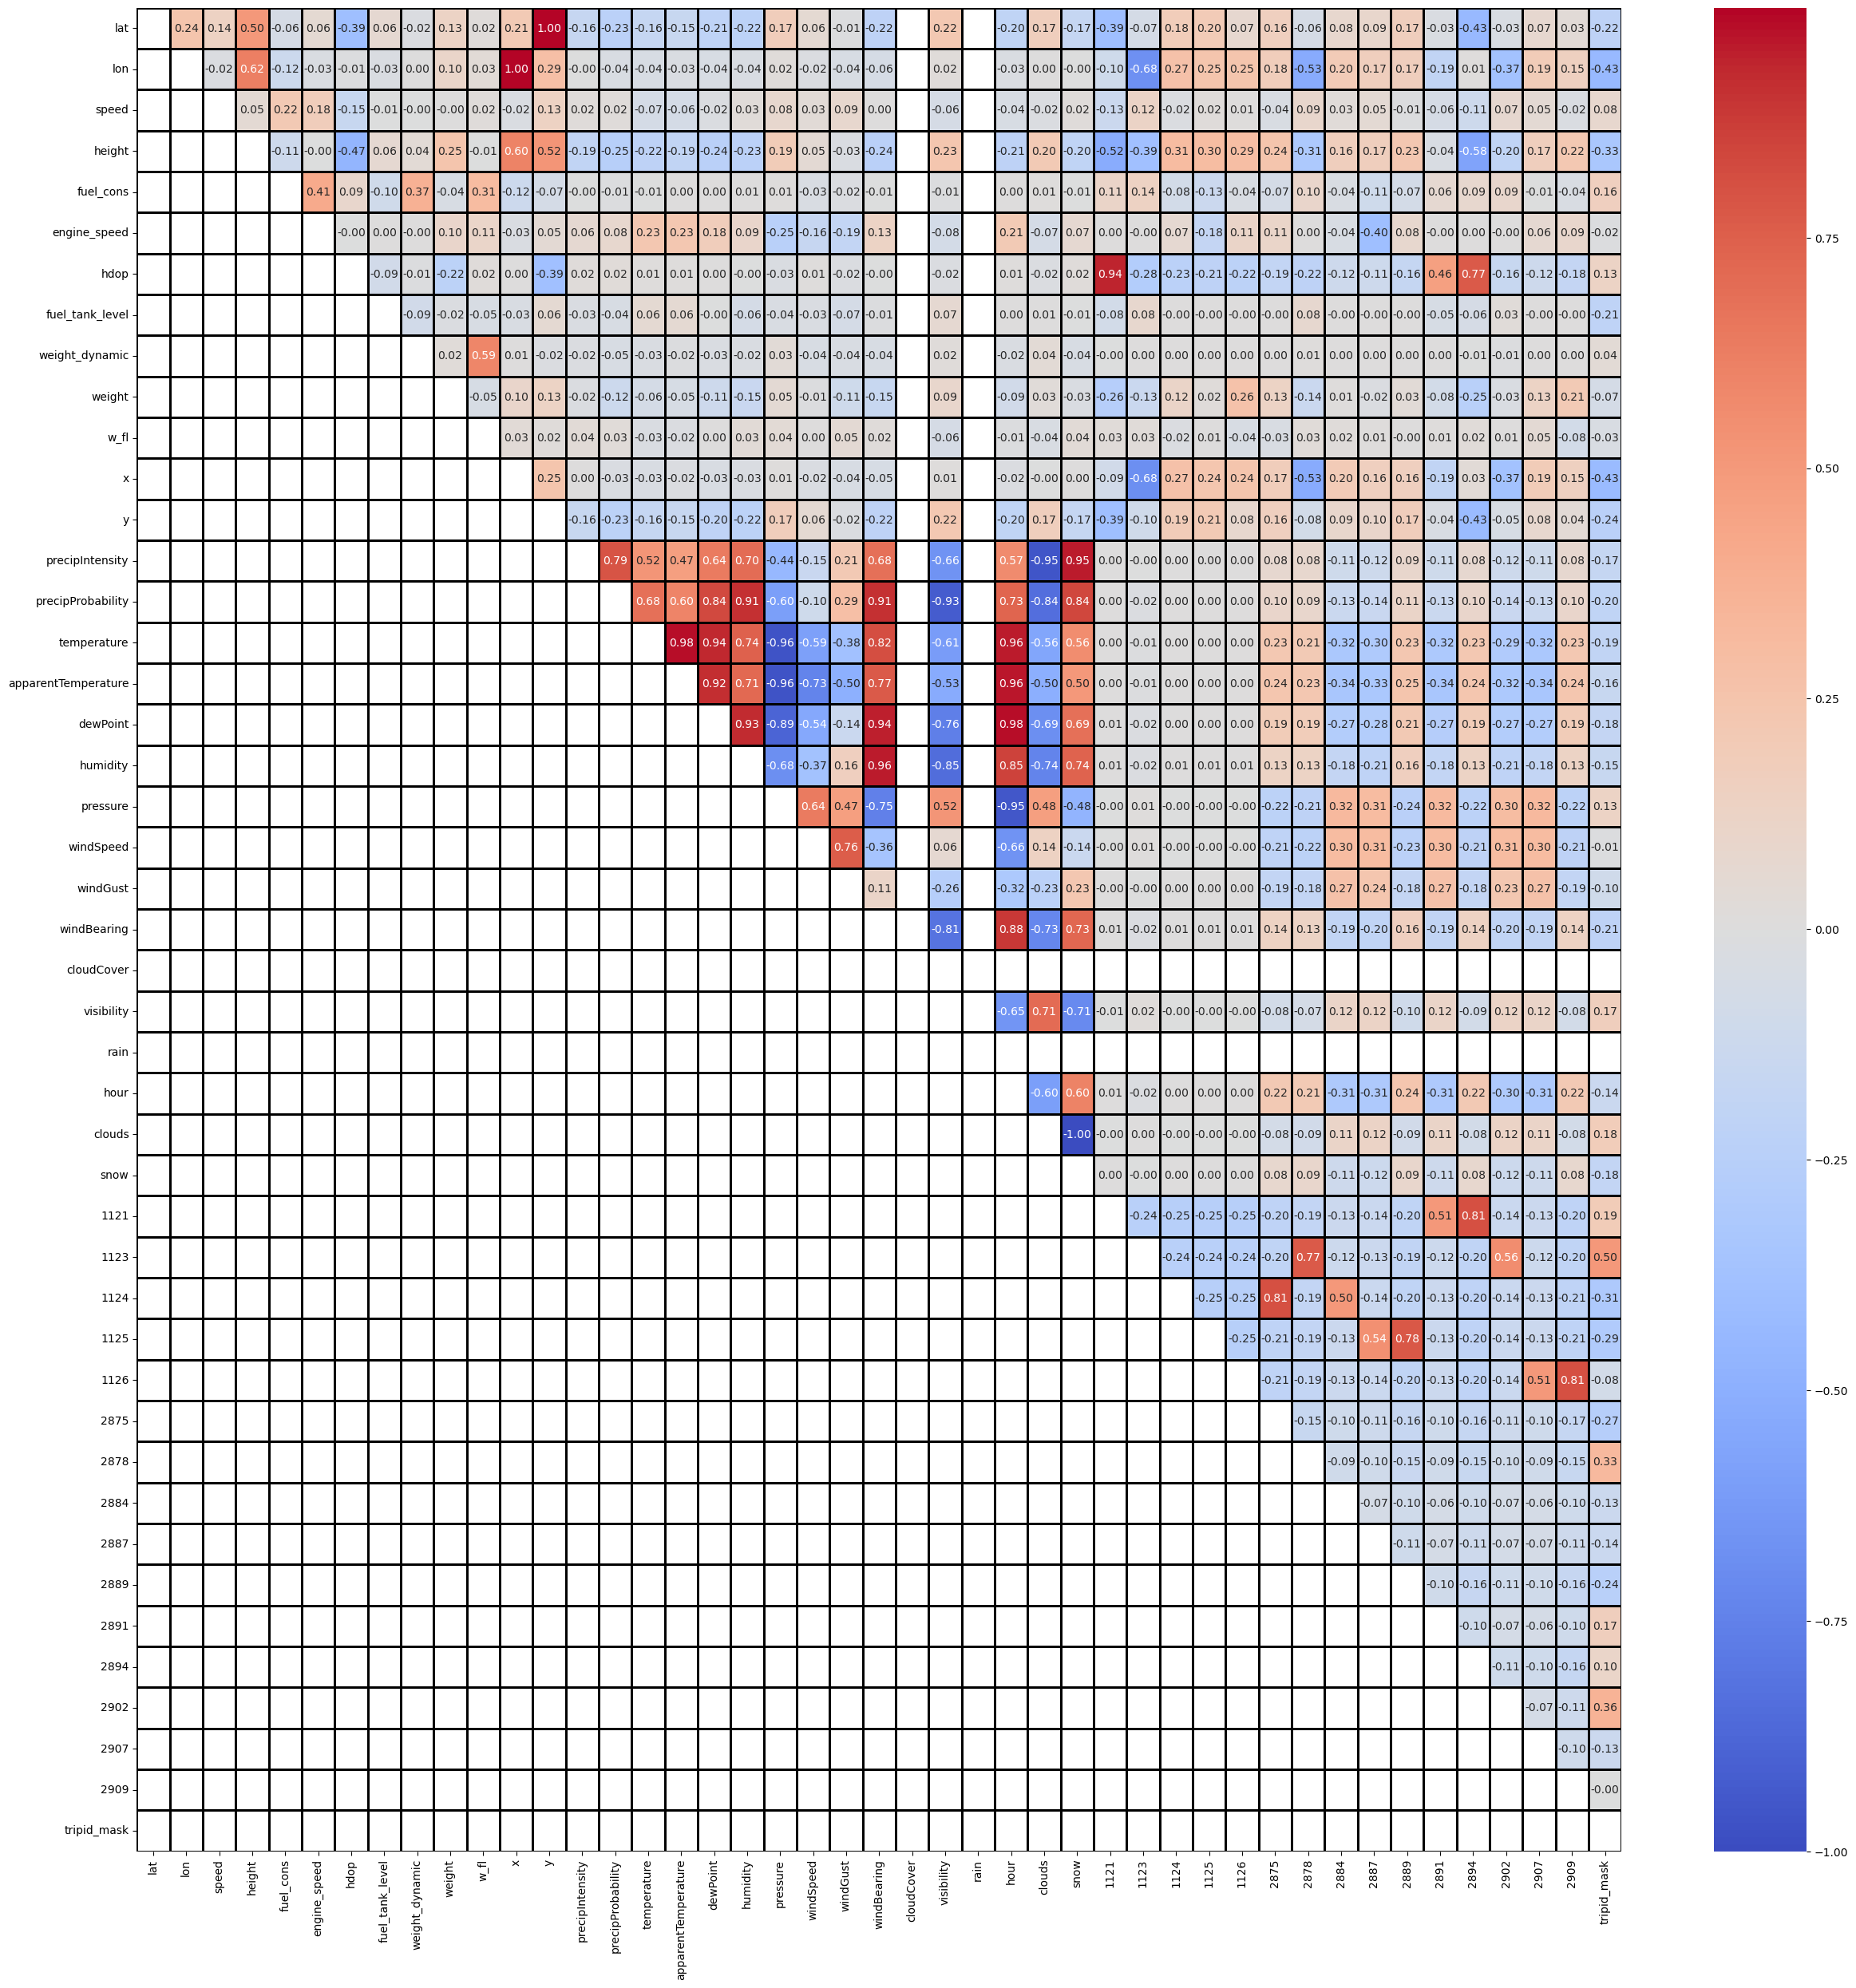

In [13]:
mask = np.tril(df.corr()) # маска треугольного вида матрицы

plt.figure(figsize = (30, 30))

sns.heatmap(df.corr(),
            annot = True, 
            fmt = '0.2f',
            cmap = 'coolwarm',
            linewidths=1, 
            linecolor='black',
            mask = mask)
plt.show()

'lat' чуть лучше коррелирует с speed чем 'y' - оставим широту и долготу, а 'x', 'y' уберем 

In [14]:
df = df.drop(['x', 'y'], axis = 1)

<a id = 'задание3_1'></a>

##### Можно (и даже нужно) генерировать дополнительные фичи.

[к оглавлению](#title) 


In [15]:
df.head()

lat        lon     speed  height  fuel_cons  engine_speed   hdop  \
0  63.328824  83.727988   3.00394   195.7      390.0   1099.331509  99.99   
1  63.336234  83.748103  19.80000   260.0      206.9   1465.000000   8.00   
2  63.343324  83.744388  15.89020   245.3      399.0   1099.331509   1.25   
3  63.342410  83.754578  26.20000   276.0      179.5   1323.750000   6.00   
4  63.335362  83.752028   0.50000   294.0       46.1    825.000000   6.00   

   fuel_tank_level  weight_dynamic  weight  ...  2878  2884  2887  2889  2891  \
0        60.000000       216.00000   215.0  ...   0.0   0.0   0.0   0.0   1.0   
1        47.990865        96.30526   211.0  ...   0.0   0.0   1.0   0.0   0.0   
2        31.000000       214.00000   214.0  ...   0.0   0.0   0.0   0.0   0.0   
3        47.990865        96.30526   215.0  ...   0.0   1.0   0.0   0.0   0.0   
4        47.990865        96.30526   220.0  ...   0.0   1.0   0.0   0.0   0.0   

   2894  2902  2907  2909  tripid_mask  
0   0.0   0.0   0.0   0.0       8795.0  
1   0.0   0.0   0.0   0.0       6456.0  
2   0.0   1.0   0.0   0.0      24863.0  
3   0.0   0.0   0.0   0.0       5210.0  
4   0.0   0.0   0.0   0.0       8500.0  

[5 rows x 43 columns]

In [16]:
df['height*ES'] = df['height'] * df['engine_speed'] # метры в минуту (скорость на подъемах)
df['fc / hei'] = df['fuel_cons'] / df['height']
df['es * fc'] = df['engine_speed'] * df['fuel_cons']

In [17]:
df_datchiki_to_corr = \
df[['speed',
    'engine_speed',
    'height',
    'fuel_cons',
    'fuel_tank_level',
    'weight_dynamic',
    'height*ES',
    'fc / hei',
    'es * fc']]


df_datchiki_to_corr.corr()['speed']


speed              1.000000
engine_speed       0.176622
height             0.053703
fuel_cons          0.217769
fuel_tank_level   -0.005693
weight_dynamic    -0.002136
height*ES          0.130446
fc / hei           0.007577
es * fc            0.256749
Name: speed, dtype: float64

Показатели корреляци:

- fc / hei   - хуже чем fuel_cons и height
- height*ES - также хуже чем просто engine_speed, прирост дает только на фоне engine_speed
- es*fc - показатель лучше чем составляющие --> оставляем

In [18]:
df = df.drop(['fc / hei', 'height*ES'], axis = 1)

<a id = 'задание3_3'></a>

##### Выбрать метрику(и) для оценки качества модели, объяснить причину выбора данной метрики

[к оглавлению](#title) 

- Я буду Стандартизировать данные, поэтому например процентные метрики (MAPE / sMAPE / RMSPE и др.) можно не брать, т.к. данные будут масштабированны
- Медианные ошибки (Например MdAE) выбирать бессмысленно (часто она игнорирует высокие отклонения)

ВЫБИРАЮ ----> RMSE как самую легко-интерпритируемую и вполне рабочую после матштабирования признаков 

<Axes: xlabel='speed', ylabel='Density'>

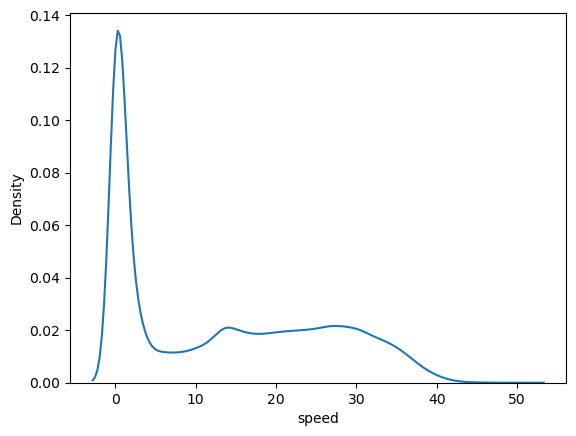

In [19]:
sns.kdeplot(data = df,
            x = 'speed')

<a id = 'задание3_4'></a>

##### Обучить несколько моделей и сравнить их. Интерпретировать результаты.

[к оглавлению](#title) 

In [20]:
df = df.sample(frac = 1, random_state = RANDOM_STATE)

y = df['speed']
X = df.drop('speed', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = RANDOM_STATE)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred = lin_model.predict(X_test)

mean_squared_error(y_test, y_pred, squared = False)

11.352628496914662

lin_model ---> 7.0917540535647685

In [22]:
%%script false

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)

mean_squared_error(y_val, y_pred, squared = False)

Couldn't find program: 'false'


RF_REG ---> 0.672015

In [23]:
%%script false

model = CatBoostRegressor( iterations = 50,
                           learning_rate = 0.5,
                           random_seed = RANDOM_STATE,
                           use_best_model = True,
                           early_stopping_rounds = 10,
                           eval_metric = 'RMSE',
                           task_type = 'GPU'
                           )

model.fit(X_train,
          y_train,
          # cat_features = np.arange(0,len(X.columns)),
          eval_set = (X_test, y_test),
          verbose = 10,
          plot = True)

model.get_params()

Couldn't find program: 'false'


In [24]:
%%script false


model = CatBoostRegressor( iterations = 1500,
                           learning_rate = 0.5,
                           random_seed = RANDOM_STATE,
                           use_best_model = True,
                           early_stopping_rounds = 20,
                           eval_metric = 'RMSE',
                           task_type = 'GPU'
                           )

model.fit(X_train,
          y_train,
          eval_set = (X_test, y_test),
          verbose = 100,
          plot = True)

model.get_params()

Couldn't find program: 'false'


CatBoost   --->     learn: 0.6414034   test: 0.8127796	best: 0.8127796 (1499)

##### Пробуем нейросетевую модель Pytorch

In [26]:
def rmse(true, predict):
    return torch.sqrt(((true - predict) ** 2).sum() / true.numel())

In [27]:
def training_loop(
          
          epoches,
          model,
          loss_fn,
          optim,

          X_train, y_train,
          X_val, y_val
):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_loss_list = []
    val_loss_list = []
    train_rmse_list = []
    val_rmse_list = []

    model = model.to(device)
    loss_fn = loss_fn.to(device)

    X_train = torch.tensor(X_train, dtype = torch.float32)
    X_val = torch.tensor(X_val, dtype = torch.float32)
    y_train = torch.tensor(y_train.to_numpy()).float()
    y_val = torch.tensor(y_val.to_numpy()).float()

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    for epoch in range(1, epoches+1):
            model.train()
            optim.zero_grad()

            predict_train = model(X_train).view(-1,1)
            y_train = y_train.view(-1,1)
            loss_train = loss_fn(predict_train, y_train)
            train_loss_list.append(loss_train.item())
            rmse_train = rmse(y_train, predict_train)
            train_rmse_list.append(rmse_train.item())

            loss_train.backward()
            optim.step()

            model.eval()
            with torch.no_grad():
                predict_val = model(X_val).view(-1,1)
                y_val = y_val.view(-1,1)
                loss_val = loss_fn(predict_val, y_val)
                val_loss_list.append(loss_val.item())
                rmse_val = rmse(y_val, predict_val)    
                val_rmse_list.append(rmse_val.item())

            if epoch == 1 or epoch % 1000 == 0:
                print(
                    'Epoch {}/{} : train loss: {:.3f}, val loss: {:.3f}, train RMSE: {:.4f}, val RMSE: {:.4f}'.\
                    
                    format(epoch, epoches, loss_train.item(), loss_val.item(), rmse_train.item(), rmse_val.item())
                )

    x = range(1, epoches + 1)
    plt.figure(figsize = (15,10))
    plt.subplot(2,1,1)
    sns.lineplot(x = x,
                    y = train_loss_list,
                    label = 'тренировочные',
                    color = 'red')
    sns.lineplot(x = x,
                    y = val_loss_list,
                    label = 'валидационные',
                    color = 'green')
    plt.grid()
    plt.legend()
    plt.xlabel('эпоха')
    plt.ylabel('mse')
    plt.title('loss(mse) и rmse на тренировочной и валидационной выборке')

    plt.subplot(2,1,2)
    sns.lineplot(
                 x = x,
                 y = train_rmse_list,
                label = 'тренировочная',
                color = 'red'
                 )
    sns.lineplot(
                    x = x,
                    y = val_rmse_list,
                    label = 'валидационная',
                    color = 'green')
    plt.grid()
    plt.xlabel('эпоха')
    plt.ylabel('rmse')
    plt.legend()
    plt.show()

    return model

Epoch 1/1000 : train loss: 330.583, val loss: 295.208, train RMSE: 18.1820, val RMSE: 17.1816
Epoch 1000/1000 : train loss: 10.405, val loss: 11.133, train RMSE: 3.2256, val RMSE: 3.3366


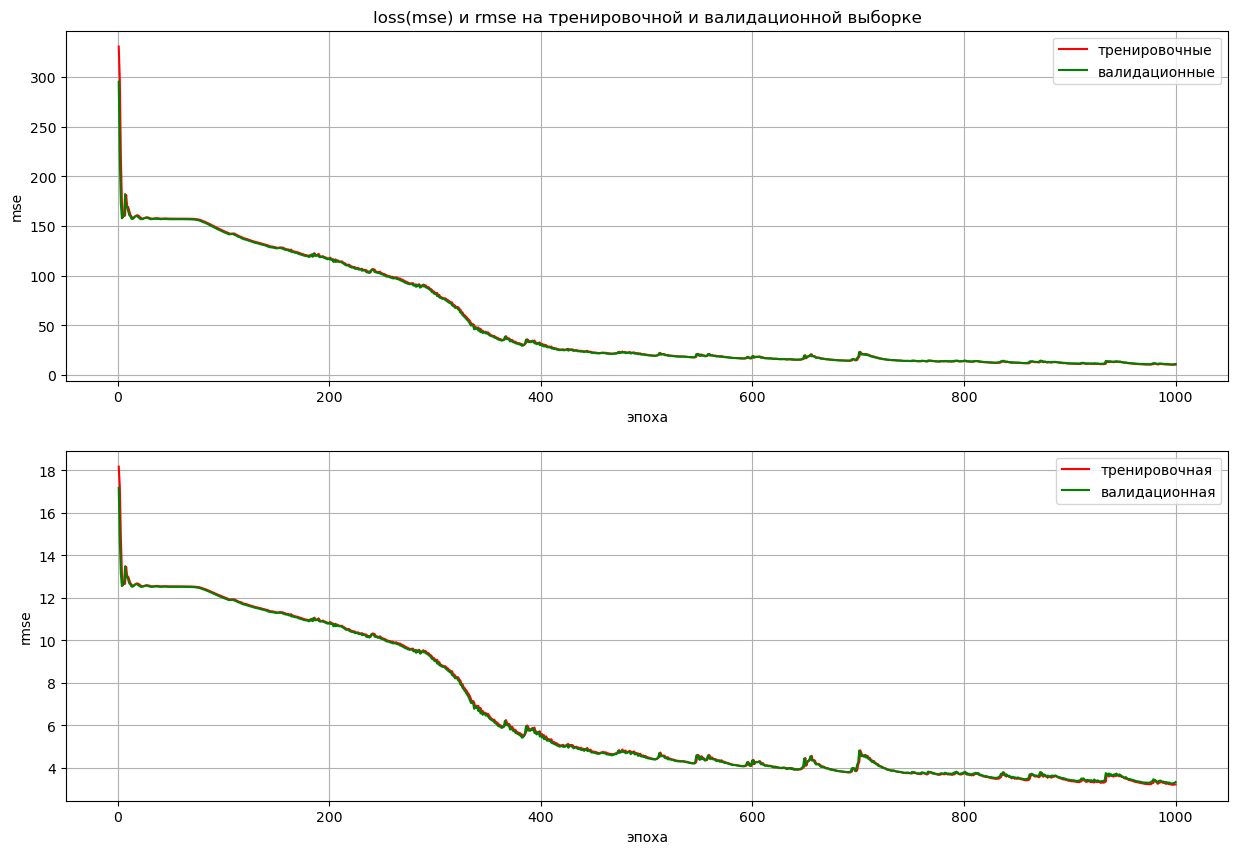

Sequential(
  (0): Linear(in_features=43, out_features=86, bias=True)
  (1): Tanh()
  (2): Linear(in_features=86, out_features=129, bias=True)
  (3): Tanh()
  (4): Linear(in_features=129, out_features=172, bias=True)
  (5): Tanh()
  (6): Linear(in_features=172, out_features=215, bias=True)
  (7): Tanh()
  (8): Linear(in_features=215, out_features=1, bias=True)
)

In [28]:
input_size = X_train.shape[1]

model = nn.Sequential(

        nn.Linear(input_size, input_size*2),
        nn.Tanh(),

        nn.Linear(input_size*2, input_size*3),
        nn.Tanh(),

        nn.Linear(input_size*3, input_size*4),
        nn.Tanh(),

        nn.Linear(input_size*4,input_size*5),
        nn.Tanh(),
        
        nn.Linear(input_size*5, 1))

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr = 0.01)

training_loop(

    epoches = 1000,
    model = model,
    loss_fn = loss_fn,
    optim = optim,

    X_train = X_train,
    y_train = y_train,

    X_val = X_test,
    y_val = y_test
)

Вывод по первым пробным моделям: 

после попыток нарастить слои и нейроны в torch моделях, а также смене оптимизаторов, оказалось: что простейшие модели RandomForest и Catboost эффективнее 

Пробуем улучшить каждую

##### RandomForest

In [29]:
%%script false

rf_model = RandomForestRegressor(random_state = RANDOM_STATE)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mean_squared_error(y_test, y_pred, squared = False)

Couldn't find program: 'false'


In [30]:
%%script false

param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt'],
    'max_depth': [6, 7, 8, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

cv = ShuffleSplit(
    n_splits = 5,
    test_size = 0.3,
    random_state = RANDOM_STATE 
)
rf_reg = RandomForestRegressor(random_state = RANDOM_STATE)

grid_search = GridSearchCV(rf_reg,
                           param_grid,
                           scoring = 'neg_root_mean_squared_error',
                           cv=cv,
                           verbose = 1,
                           n_jobs = 10)
best_model = grid_search.fit(X_train,y_train)

Couldn't find program: 'false'


In [31]:
%%script false

param_grid = {
    'n_estimators': [600],
    'max_features': ['sqrt'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf_reg = RandomForestRegressor(random_state = RANDOM_STATE)

cv = ShuffleSplit(
    n_splits = 5,
    test_size = 0.3,
    random_state = RANDOM_STATE 
)

grid_search = GridSearchCV(rf_reg,
                           param_grid,
                           scoring = 'neg_root_mean_squared_error',
                           cv=cv,
                           verbose = 0,
                           n_jobs = 1,
                           error_score = 'raise')
best_model_n_estim_try = grid_search.fit(X_train,y_train)

Couldn't find program: 'false'


-2.16

In [32]:
%%script false

param_grid = {
    'n_estimators': np.arange(700,1100, 100),
    'max_features': ['sqrt'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf_reg = RandomForestRegressor(random_state = RANDOM_STATE)

cv = ShuffleSplit(
    n_splits = 5,
    test_size = 0.3,
    random_state = RANDOM_STATE 
)

grid_search = GridSearchCV(rf_reg,
                           param_grid,
                           scoring = 'neg_root_mean_squared_error',
                           cv=cv,
                           verbose = 0,
                           n_jobs = 1,
                           error_score = 'raise')
best_model_n_estim_try = grid_search.fit(X_train,y_train)

Couldn't find program: 'false'


-2.15

In [33]:
%%script false

param_grid = {
    'n_estimators': [500],
    'max_features': ['sqrt'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf_reg = RandomForestRegressor(random_state = RANDOM_STATE)

cv = ShuffleSplit(
    n_splits = 5,
    test_size = 0.3,
    random_state = RANDOM_STATE 
)

grid_search = GridSearchCV(rf_reg,
                           param_grid,
                           scoring = 'neg_root_mean_squared_error',
                           cv=cv,
                           verbose = 0,
                           n_jobs = 1,
                           error_score = 'raise')
best_model_n_estim_try = grid_search.fit(X_train,y_train)



print(best_model_n_estim_try.cv_results_['mean_test_score'])
print(best_model_n_estim_try.best_score_)
print(best_model_n_estim_try.best_params_)

Couldn't find program: 'false'


In [34]:
%%script false

param_grid = {
    'n_estimators': [600],
    'max_features': ['sqrt'],
    'max_depth': [24],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf_reg = RandomForestRegressor(random_state = RANDOM_STATE)

cv = ShuffleSplit(
    n_splits = 5,
    test_size = 0.3,
    random_state = RANDOM_STATE 
)

grid_search = GridSearchCV(rf_reg,
                           param_grid,
                           scoring = 'neg_root_mean_squared_error',
                           cv=cv,
                           verbose = 0,
                           n_jobs = 1,
                           error_score = 'raise')
best_model_n_estim_try = grid_search.fit(X_train,y_train)



print(best_model_n_estim_try.cv_results_['mean_test_score'])
print(best_model_n_estim_try.best_score_)
print(best_model_n_estim_try.best_params_)

Couldn't find program: 'false'


In [35]:
%%script false

param_grid = {
    'n_estimators': [100,200,300,400,500],
    'max_features': ['sqrt'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf_reg = RandomForestRegressor(random_state = RANDOM_STATE)

cv = ShuffleSplit(
    n_splits = 5,
    test_size = 0.3,
    random_state = RANDOM_STATE 
)

grid_search = GridSearchCV(rf_reg,
                           param_grid,
                           scoring = 'neg_root_mean_squared_error',
                           cv=cv,
                           verbose = 0,
                           n_jobs = 7)
best_model_n_estim_try = grid_search.fit(X_train,y_train)


print(best_model_n_estim_try.cv_results_['mean_test_score'])
print(best_model_n_estim_try.best_score_)
print(best_model_n_estim_try.best_params_)

Couldn't find program: 'false'


In [36]:
%%script false

params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 2500
params['random_seed'] = RANDOM_STATE
params['learning_rate'] = 0.5

cv_data = cv(params = params,
             pool = Pool(data = X_train,
                         label = y_train,
                         ),
             fold_count = 5,
             shuffle = True,
             partition_random_seed = RANDOM_STATE,
             plot = True,
             verbose = False)

Couldn't find program: 'false'


In [37]:
%%script false


params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 3000
params['random_seed'] = RANDOM_STATE
params['learning_rate'] = 0.5

cv_data = cv(params = params,
             pool = Pool(data = X_train,
                         label = y_train,
                         ),
             fold_count = 5,
             shuffle = True,
             partition_random_seed = RANDOM_STATE,
             plot = True,
             verbose = False)

Couldn't find program: 'false'


In [38]:
%%script false

params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 4000
params['random_seed'] = RANDOM_STATE
params['learning_rate'] = 0.5

cv_data = cv(params = params,
             pool = Pool(data = X_train,
                         label = y_train,
                         ),
             fold_count = 5,
             shuffle = True,
             partition_random_seed = RANDOM_STATE,
             plot = True,
             verbose = False)

Couldn't find program: 'false'


In [39]:
%%script false


params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 5000
params['random_seed'] = RANDOM_STATE
params['learning_rate'] = 0.7

cv_data = cv(params = params,
             pool = Pool(data = X_train,
                         label = y_train,
                         ),
             fold_count = 5,
             shuffle = True,
             partition_random_seed = RANDOM_STATE,
             plot = True,
             verbose = False)

Couldn't find program: 'false'


In [40]:
%%script false


params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 7000
params['random_seed'] = RANDOM_STATE
params['learning_rate'] = 0.5

cv_data = cv(params = params,
             pool = Pool(data = X_train,
                         label = y_train,
                         ),
             fold_count = 5,
             shuffle = True,
             partition_random_seed = RANDOM_STATE,
             plot = True,
             verbose = False)

Couldn't find program: 'false'


Training on fold [0/5]

bestTest = 1.947814326
bestIteration = 6999

Training on fold [1/5]

bestTest = 1.955841315
bestIteration = 6998

Training on fold [2/5]

bestTest = 1.978691436
bestIteration = 6999

Training on fold [3/5]

bestTest = 1.925983838
bestIteration = 6999

Training on fold [4/5]

bestTest = 1.958680612
bestIteration = 6984



In [41]:
%%script false


params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 5000
params['random_seed'] = RANDOM_STATE
params['learning_rate'] = 0.7

cv_data = cv(params = params,
             pool = Pool(data = X_train,
                         label = y_train,
                         ),
             fold_count = 5,
             shuffle = True,
             partition_random_seed = RANDOM_STATE,
             plot = True,
             verbose = False)

Couldn't find program: 'false'


Training on fold [0/5]

bestTest = 2.08833273
bestIteration = 4998

Training on fold [1/5]

bestTest = 2.073518509
bestIteration = 4949

Training on fold [2/5]

bestTest = 2.091579712
bestIteration = 4996

Training on fold [3/5]

bestTest = 2.046377173
bestIteration = 4999

Training on fold [4/5]

bestTest = 2.077706628
bestIteration = 4999



In [42]:
%%script false


params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 5000
params['random_seed'] = RANDOM_STATE
params['learning_rate'] = 0.5

cv_data = cv(params = params,
             pool = Pool(data = X_train,
                         label = y_train,
                         ),
             fold_count = 5,
             shuffle = True,
             partition_random_seed = RANDOM_STATE,
             plot = True,
             verbose = False)

Couldn't find program: 'false'




Training on fold [0/5]

bestTest = 2.007332556
bestIteration = 4999

Training on fold [1/5]

bestTest = 2.012593868
bestIteration = 4999

Training on fold [2/5]

bestTest = 2.029585038
bestIteration = 4999

Training on fold [3/5]

bestTest = 1.98476258
bestIteration = 4998

Training on fold [4/5]

bestTest = 2.016171823
bestIteration = 4999



In [43]:
%%script false


params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 5000
params['random_seed'] = RANDOM_STATE
params['learning_rate'] = 0.5

cv_data = cv(params = params,
             pool = Pool(data = X_train,
                         label = y_train,
                         ),
             fold_count = 5,
             shuffle = True,
             partition_random_seed = RANDOM_STATE,
             plot = True,
             verbose = False)

Couldn't find program: 'false'


Training on fold [0/5]

bestTest = 2.007332556
bestIteration = 4999

Training on fold [1/5]

bestTest = 2.012593868
bestIteration = 4999

Training on fold [2/5]

bestTest = 2.029585038
bestIteration = 4999

Training on fold [3/5]

bestTest = 1.98476258
bestIteration = 4998

Training on fold [4/5]

bestTest = 2.016171823
bestIteration = 4999



In [44]:
%%script false


params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 2000
params['random_seed'] = RANDOM_STATE
params['learning_rate'] = 0.01

cv_data = cv(params = params,
             pool = Pool(data = X_train,
                         label = y_train,
                         ),
             fold_count = 5,
             shuffle = True,
             partition_random_seed = RANDOM_STATE,
             plot = True,
             verbose = False)

Couldn't find program: 'false'


Training on fold [0/5]

bestTest = 4.546127859
bestIteration = 1999

Training on fold [1/5]

bestTest = 4.611353124
bestIteration = 1999

Training on fold [2/5]

bestTest = 4.551881164
bestIteration = 1999

Training on fold [3/5]

bestTest = 4.531097902
bestIteration = 1999

Training on fold [4/5]

bestTest = 4.575318993
bestIteration = 1999

In [45]:
%%script false


params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 4000
params['random_seed'] = RANDOM_STATE
params['learning_rate'] = 0.05

cv_data = cv(params = params,
             pool = Pool(data = X_train,
                         label = y_train,
                         ),
             fold_count = 5,
             shuffle = True,
             partition_random_seed = RANDOM_STATE,
             plot = True,
             verbose = False)

Couldn't find program: 'false'


Training on fold [0/5]

bestTest = 2.824582093
bestIteration = 3999

Training on fold [1/5]

bestTest = 2.867287955
bestIteration = 3999

Training on fold [2/5]

bestTest = 2.851745649
bestIteration = 3999

Training on fold [3/5]

bestTest = 2.809633984
bestIteration = 3999

Training on fold [4/5]

bestTest = 2.848379025
bestIteration = 3999



In [46]:
%%script false

params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 2000
params['random_seed'] = RANDOM_STATE
params['learning_rate'] = 0.5

cv_data = cv(params = params,
             pool = Pool(data = X_train,
                         label = y_train,
                         ),
             fold_count = 5,
             shuffle = True,
             partition_random_seed = RANDOM_STATE,
             plot = True,
             verbose = False)

Couldn't find program: 'false'


Training on fold [0/5]

bestTest = 2.258239813
bestIteration = 1998

Training on fold [1/5]

bestTest = 2.270539698
bestIteration = 1999

Training on fold [2/5]

bestTest = 2.27670927
bestIteration = 1999

Training on fold [3/5]

bestTest = 2.231767831
bestIteration = 1999

Training on fold [4/5]

bestTest = 2.271577683
bestIteration = 1999



In [47]:
%%script false


params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 10000
params['random_seed'] = RANDOM_STATE
params['learning_rate'] = 0.5

cv_data = cv(params = params,
             pool = Pool(data = X_train,
                         label = y_train,
                         ),
             fold_count = 5,
             shuffle = True,
             partition_random_seed = RANDOM_STATE,
             plot = True,
             verbose = False)

Couldn't find program: 'false'


Training on fold [0/5]

bestTest = 1.900932225
bestIteration = 9999

Training on fold [1/5]

bestTest = 1.915775559
bestIteration = 9978

Training on fold [2/5]

bestTest = 1.93184646
bestIteration = 9998

Training on fold [3/5]

bestTest = 1.882181459
bestIteration = 9996

Training on fold [4/5]

bestTest = 1.914216298
bestIteration = 9999

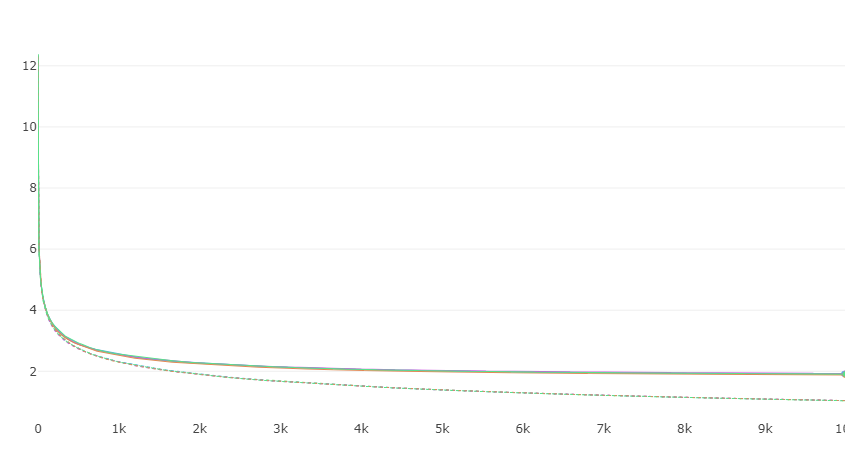

<a id = 'itog_1'></a>

## Вывод по опробованным моделям

[к оглавлению](#title)

Пробовали 4 регресионные модели с разным подходом:

- Линейная регрессия (базовая модель)
- RandomForest
    - после Gridsearch с перемешиванием (необходимоЮ т.к. у нас упорядочивание по временным данным) и крос-валидацией, выяснилось --> выйти за пределы RMSE = 2.16 (не считая незначительное уменьшение ошибки в сотых) не получилось
- Нейросеть (градиентный спуск)
    - наращивание слоев и кол-ва нейронов не помогло преодалеть границу в RMSE = 3.33
    - к переобучению модель не была склонна
- Catboost (градиентный бустинг)


---


Наилучшие результатыв показала модель бустинга (lr = 0.5, iters = 6000 - 10000) ---> После кросс валидации -- RMSE = 1.91

- после 8000 - 9000 итераций ошибка уменьшается на незначительные сотые
- есть небольшое переобучение, которое нормально после стольких интераций ( + такое переобучение нормально (нет большого отклонения, есть общая тенденция к снижению RMSE))

<a id = 'itog_2'></a>

## Тренировка итоговой модели

[к оглавлению](#title)

In [52]:
model = CatBoostRegressor( iterations = 10000,
                           learning_rate = 0.5,
                           random_seed = RANDOM_STATE,
                           use_best_model = True,
                           early_stopping_rounds = 100, 
                           eval_metric = 'RMSE',
                           task_type = 'GPU')

model.fit(X_train,
          y_train,
          eval_set = (X_test, y_test),
          verbose = 1000,
          plot = True)

model.get_params()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 10.3269292	test: 10.2920688	best: 10.2920688 (0)	total: 5.15ms	remaining: 51.5s
1000:	learn: 2.4020876	test: 2.5683665	best: 2.5683665 (1000)	total: 4.01s	remaining: 36s
2000:	learn: 2.0310997	test: 2.2813531	best: 2.2813531 (2000)	total: 7.95s	remaining: 31.8s
3000:	learn: 1.8294407	test: 2.1450465	best: 2.1450465 (3000)	total: 11.9s	remaining: 27.8s
4000:	learn: 1.6952062	test: 2.0615268	best: 2.0615268 (4000)	total: 16s	remaining: 24s
5000:	learn: 1.5923346	test: 2.0054378	best: 2.0054378 (5000)	total: 20.3s	remaining: 20.3s
6000:	learn: 1.5101641	test: 1.9631522	best: 1.9631522 (6000)	total: 24.6s	remaining: 16.4s
7000:	learn: 1.4461912	test: 1.9340154	best: 1.9339944 (6997)	total: 28.7s	remaining: 12.3s
8000:	learn: 1.3937134	test: 1.9115173	best: 1.9115173 (8000)	total: 32.7s	remaining: 8.16s
9000:	learn: 1.3464372	test: 1.8950008	best: 1.8950008 (9000)	total: 36.7s	remaining: 4.07s
9999:	learn: 1.3055423	test: 1.8785460	best: 1.8785290 (9998)	total: 40.5s	remaining: 0u

{'iterations': 10000,
 'learning_rate': 0.5,
 'loss_function': 'RMSE',
 'random_seed': 42,
 'use_best_model': True,
 'eval_metric': 'RMSE',
 'task_type': 'GPU',
 'early_stopping_rounds': 100}

- наилучшей моделью оказалась модель градиентного бустинга Catboost
- RMSE = 1.87